# Compare hologram data with MERRA2 on PWV

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2024-10-15 :
- last update 2024-10-16 (faint,bright, polar or not)
- last update 2024-10-17 with version v5
- last update 2024-10-18 : SupperImpose 2022,2023,2024
- last update : 2024-10-19 : Correct bugs on individual night curves
- last update : 2024-11-06 : Pressure effect
- Kernel @usdf **w_2024_38*
- Office emac : mamba_py311
- Home emac : base (conda)
- laptop : conda_py310

**Goal** : Show correlation holo /Merra

In [1]:
from platform import python_version
print(python_version())

3.10.15


In [2]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [3]:
from platform import python_version
print(python_version())

3.10.15


In [4]:
import os

In [5]:
# where are stored the figures
pathfigs = "figsHoloMerra2PWV"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".png"

In [6]:
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit,least_squares


# new color correction model
import pickle
from scipy.interpolate import RegularGridInterpolator

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [8]:
# Remove to run faster the notebook
#import ipywidgets as widgets
#%matplotlib widget

In [9]:
from importlib.metadata import version

In [10]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [11]:
np.__version__

'2.1.2'

In [12]:
pd.__version__

'2.2.3'

In [13]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

## Configuration

In [14]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

### Spectro Hologram data

In [15]:
FLAG_WITHCOLLIMATOR = True
DATE_WITHCOLLIMATOR = 20230930
datetime_WITHCOLLIMATOR = convertNumToDatestr(DATE_WITHCOLLIMATOR)
datetime_WITHCOLLIMATOR = pd.to_datetime("2023-09-30 00:00:00.0+0000")
datetime_WITHCOLLIMATOR

Timestamp('2023-09-30 00:00:00+0000', tz='UTC')

In [16]:
version_results = "v5"
legendtag = {"v1" : "old v3.1.0",
            "v2" : "v3.1.0-PWV<10mm",
            "v3" : "v3.1.0-PWV<15mm",
            "v4" : "Auxtel holo v3.1.0",
            "v5" : "Auxtel holo v3.1.0 09/22 - 10/24"}

In [17]:
atmfilenamesdict = {"v1" : "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy",
                    "v2" : "auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_PeekFinder.npy",
                    "v3" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z.npy",
                    "v4" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z_spectrfullextend.npy",
                    "v5" : "u_dagoret_auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip_20241016T184601Z_spectrfullextended.npy"}

In [18]:
atmfilename = atmfilenamesdict[version_results]
tag = legendtag[version_results] 

### MERRA2

In [19]:
filename_m2 = "../SpectroMerra2/MerradataMerged/Merge_inst1_2d_asm_Nx_M2I1NXASM-2021-2024.csv"

In [20]:
df_m = pd.read_csv(filename_m2)

## Initialisation

### Read the file

In [21]:
specdata = np.load(atmfilename,allow_pickle=True)

In [22]:
df_spec = pd.DataFrame(specdata)

In [23]:
list(df_spec.columns)

['DATE-OBS',
 'id',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'TARGET',
 'REDSHIFT',
 'GRATING',
 'ROTANGLE',
 'D2CCD',
 'LSHIFT',
 'DOMEAZ',
 'AZ',
 'EL',
 'RA',
 'MJD',
 'WINDSPD',
 'WINDDIR',
 'PARANGLE',
 'TARGETX',
 'TARGETY',
 'LBDA_REF',
 'PSF_REG',
 'TRACE_R',
 'MEANFWHM',
 'PIXSHIFT',
 'CHI2_FIT',
 'A2_FIT',
 'AM_FIT',
 'VERSION',
 'CCD_REBIN',
 'CONFIG',
 'EXPTIME',
 'AIRMASS',
 'DEC',
 'HA',
 'OUTTEMP',
 'OUTPRESS',
 'OUTHUM',
 'FILTER',
 'CAM_ROT',
 'S_X0',
 'S_Y0',
 'S_XMIN',
 'S_XMAX',
 'S_YMIN',
 'S_YMAX',
 'S_NX',
 'S_NY',
 'S_DEG',
 'S_SAT',
 'S_ORDER',
 'A1_x',
 'A1_err_x',
 'A2_x',
 'A2_err_x',
 'A3',
 'A3_err',
 'VAOD_x',
 'VAOD_err_x',
 'angstrom_exp_x',
 'angstrom_exp_err_x',
 'ozone [db]_x',
 'ozone [db]_err_x',
 'PWV [mm]_x',
 'PWV [mm]_err_x',
 'B_x',
 'B_err_x',
 'A_star',
 'A_star_err',
 'D_CCD [mm]_x',
 'D_CCD [mm]_err_x',
 'shift_x [pix]',
 'shift_x [pix]_err',
 'shift_y [pix]',
 'shift_y [pix]_err',
 'angle [deg]',
 'angle [deg]_err',
 'P [hPa

### Define if a target is faint or bright

In [24]:
def IsFaint(row):
    List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
    List_Of_faint_selected = List_Of_Faint_targets[:10]
    if row["TARGET"] in List_Of_faint_selected:
        return True
    else:
        return False

In [25]:
df_spec["isFaint"] = df_spec.apply(IsFaint,axis=1)

### Compute NightObs

In [26]:
df_spec["nightObs"] = df_spec.apply(lambda x: x['id']//100_000, axis=1)

In [27]:
if FLAG_WITHCOLLIMATOR:
    df_spec = df_spec[df_spec["nightObs"]> DATE_WITHCOLLIMATOR]

## Apply Quality selection

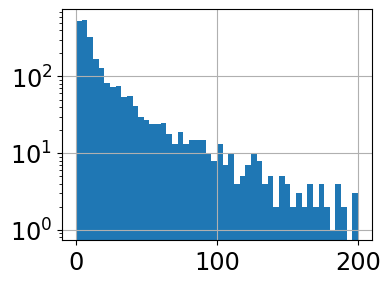

In [28]:
fig,ax = plt.subplots(1,1)
df_spec["CHI2_FIT"].hist(bins=50,ax=ax,range=(0,200))
ax.set_yscale("log")

### Add the Time in pd.datetime

#### UTC

In [29]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])

In [30]:
DT = pd.Timedelta(minutes=7*24*60)
TMIN  = df_spec["Time"].min()-DT
TMAX  = df_spec["Time"].max()+DT

### Compute relative time to Mid-night

In [31]:
def GetTimeToMidNight(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(local_time.year,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
    local_time_midnight = datetime(local_time_new.year,local_time_new.month,local_time_new.day)
    dt_hour = (local_time_new -local_time_midnight).seconds/3600.

    # we took the previous night mid-night , must subtract 24H
    if dt_hour > 12.:
        dt_hour_new = (dt_hour - 24.)
    else:
        dt_hour_new = dt_hour
        
    return dt_hour_new

In [32]:
df_spec["dt_midnight"] = df_spec.apply(GetTimeToMidNight,axis=1)

Text(0.5, 1.0, 'Observation time')

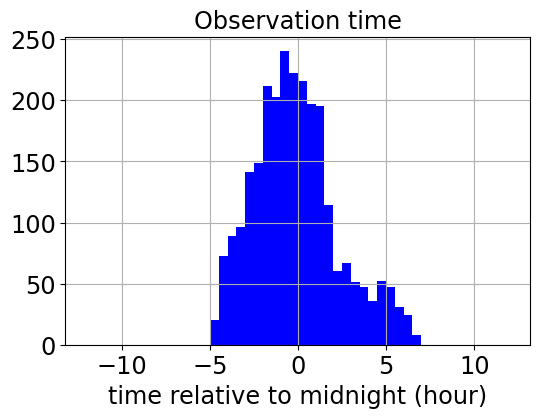

In [33]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
df_spec["dt_midnight"].hist(bins=48,range=(-12,12),ax=ax,facecolor="blue") 
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Observation time")

### Compute Date relative to January

In [34]:
def GetDateToMidJanuary(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new)

In [35]:
#df_spec["Time_january"] = df_spec.apply(GetDateToMidJanuary,axis=1)

In [36]:
def GetDateToMidJanuaryAndYear(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new),local_time.year 

In [37]:
df_spec[["Time_january","Year"]] = df_spec.apply(GetDateToMidJanuaryAndYear,axis=1,result_type="expand")

In [38]:
df_spec[["Time_january","Year"]]

Time_january  Year
3329 2024-10-10 23:02:25  2023
3330 2024-10-10 23:03:38  2023
3331 2024-10-10 23:25:46  2023
3332 2024-10-10 23:26:59  2023
3333 2024-10-10 23:34:11  2023
...                  ...   ...
5914 2024-10-16 05:33:33  2024
5915 2024-10-16 05:41:00  2024
5916 2024-10-16 05:42:13  2024
5917 2024-10-16 05:49:45  2024
5918 2024-10-16 05:50:58  2024

[2590 rows x 2 columns]

## Compute night boundaries

In [39]:
def GetNightBoundariesDict(df_spec):
    """
    input:
      df_spec the dataframe for spectroscopy summary results
    output:
      the dict of night boudaries
    """
    
    Dt = pd.Timedelta(minutes=30)
    d = {}
    list_of_nightobs = df_spec["nightObs"].unique()
    for nightobs in list_of_nightobs:
        sel_flag = df_spec["nightObs"]== nightobs
        df_night = df_spec[sel_flag]
        tmin = df_night["Time"].min()-Dt
        tmax = df_night["Time"].max()+Dt
        d[nightobs] = (tmin,tmax)
    return d

In [40]:
dn = GetNightBoundariesDict(df_spec)

## Plot all data

In [47]:
cut  = ~(df_spec["OUTPRESS"] == 743.00) 

In [41]:
TMIN

Timestamp('2023-10-04 02:02:25.365492420+0000', tz='UTC')

In [42]:
type(datetime_WITHCOLLIMATOR)

pandas._libs.tslibs.timestamps.Timestamp

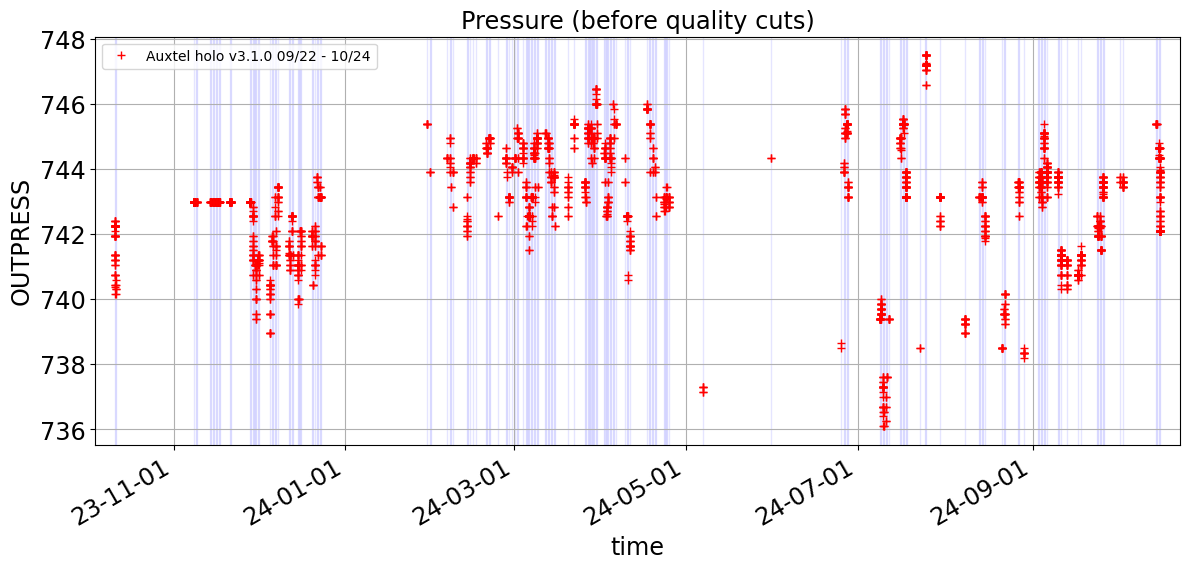

In [43]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
#df_m.plot(x="Time",y="PShP",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec.plot(x="Time",y="OUTPRESS",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("OUTPRESS")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Pressure (before quality cuts)")
ax.legend()

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.set_ylim(0.,15.)

figname =f"{pathfigs}/pressure_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()


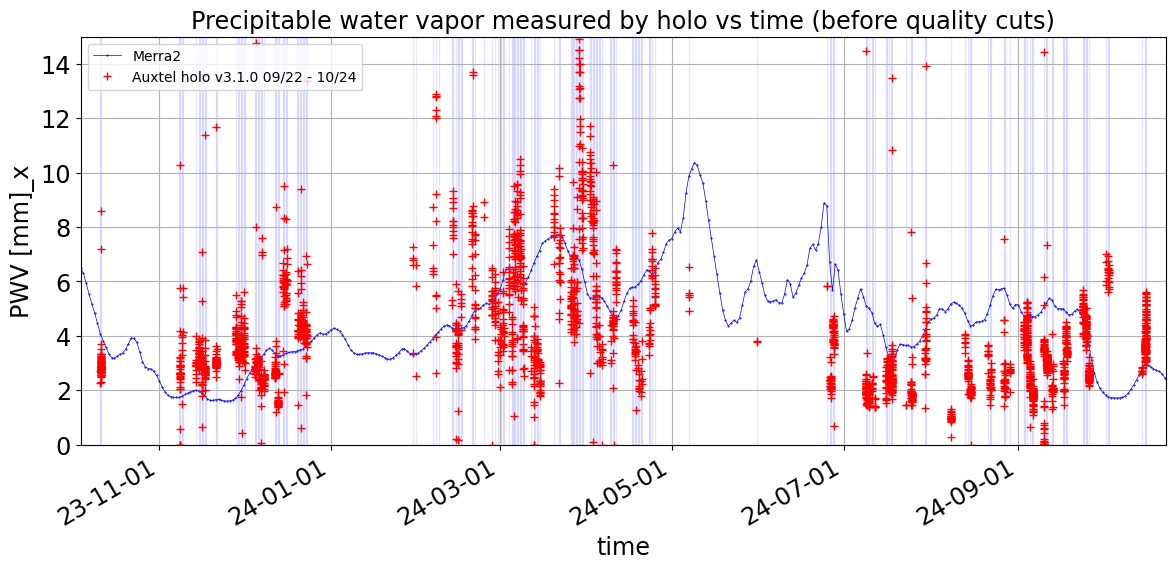

In [45]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TQV",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("PWV [mm]_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Precipitable water vapor measured by holo vs time (before quality cuts)")
ax.legend()

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


ax.set_ylim(0.,15.)

figname =f"{pathfigs}/pwv_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()


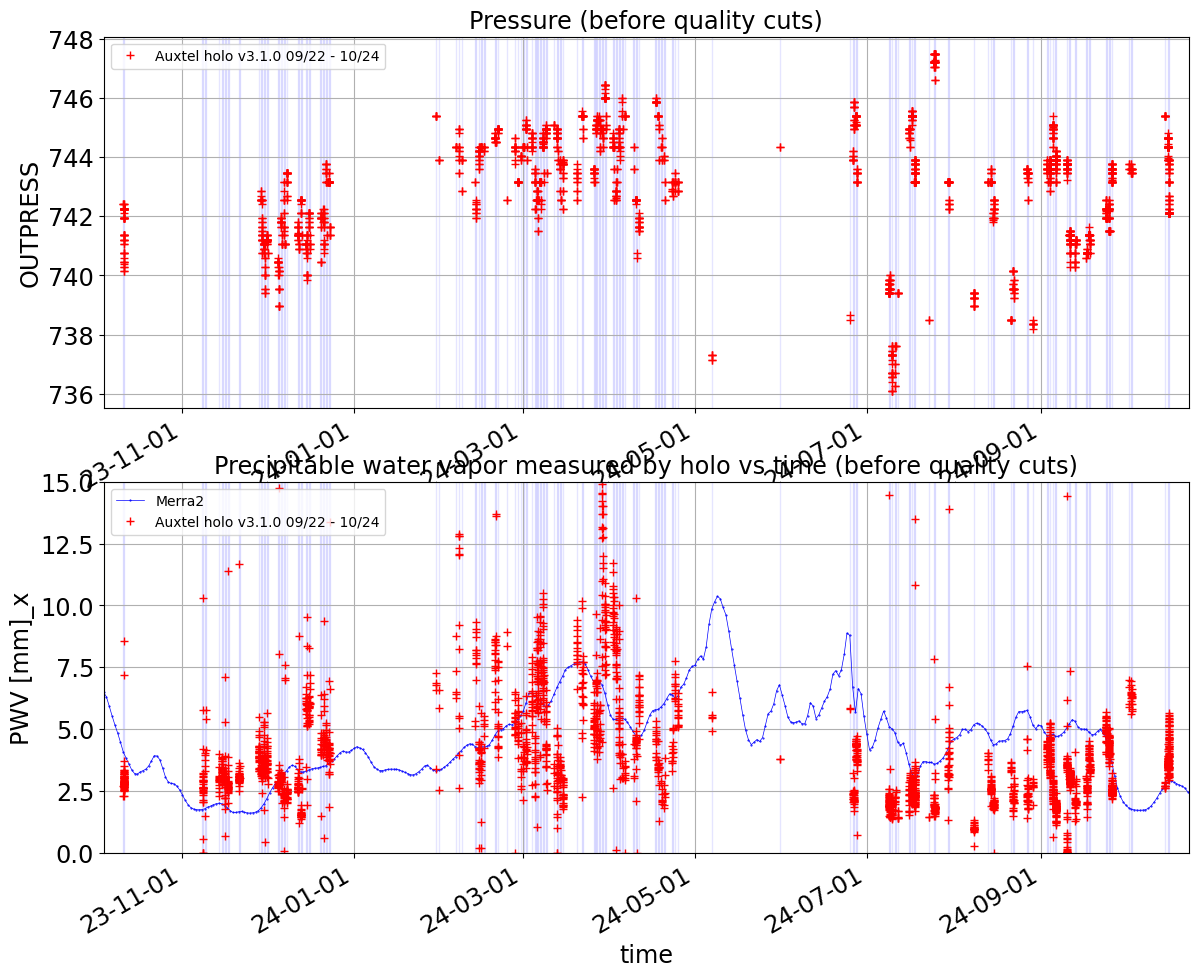

In [48]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(2,1,figsize=(14,12))
ax  = axs[0]
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
#df_m.plot(x="Time",y="PShP",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec[cut].plot(x="Time",y="OUTPRESS",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("OUTPRESS")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Pressure (before quality cuts)")
ax.legend()

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.set_ylim(0.,15.)

ax  = axs[1]
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TQV",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("PWV [mm]_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Precipitable water vapor measured by holo vs time (before quality cuts)")
ax.legend()

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)



ax.set_ylim(0.,15.)





figname =f"{pathfigs}/pressureandpwv_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()


<Axes: xlabel='OUTPRESS', ylabel='PWV [mm]_x'>

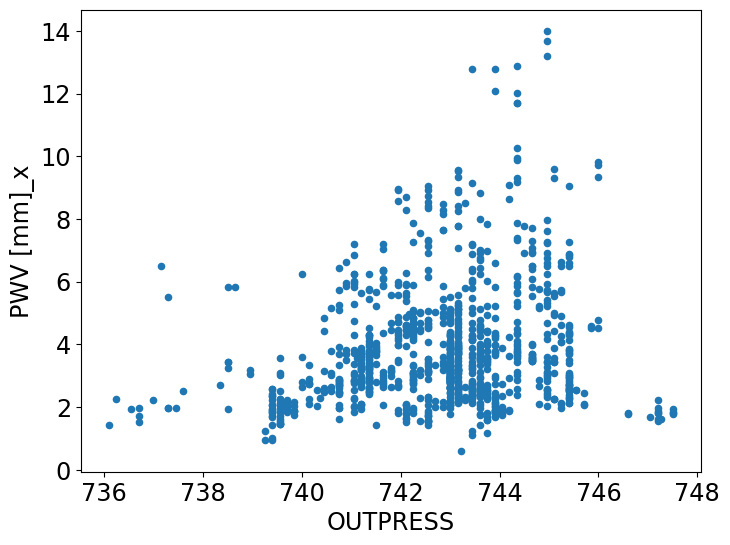

In [75]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
df_spec[cut].plot.scatter(y="PWV [mm]_x",x="OUTPRESS",ax=ax)

In [76]:
df_spec

DATE-OBS             id  BITPIX  NAXIS  \
3329 2023-10-11 02:02:25.365492420+00:00  2023101000327     -64      2   
3330 2023-10-11 02:03:38.283006786+00:00  2023101000328     -64      2   
3331 2023-10-11 02:25:46.229492465+00:00  2023101000344     -64      2   
3332 2023-10-11 02:26:59.188999220+00:00  2023101000345     -64      2   
3333 2023-10-11 02:34:11.494504202+00:00  2023101000351     -64      2   
...                                  ...            ...     ...    ...   
5914 2024-10-16 08:33:33.312004869+00:00  2024101500703     -64      2   
5915 2024-10-16 08:41:00.317505706+00:00  2024101500709     -64      2   
5916 2024-10-16 08:42:13.368508242+00:00  2024101500710     -64      2   
5917 2024-10-16 08:49:45.279500302+00:00  2024101500716     -64      2   
5918 2024-10-16 08:50:58.256508188+00:00  2024101500717     -64      2   

      NAXIS1  NAXIS2  EXTEND    TARGET  REDSHIFT    GRATING  ROTANGLE  \
3329    1020       3    True  HD205905 -0.000057  holo4_003  0.231370   
3330    1021       3    True  HD205905 -0.000057  holo4_003  0.226808   
3331    1021       3    True    HD2811  0.000000  holo4_003  0.228610   
3332    1021       3    True    HD2811  0.000000  holo4_003  0.223949   
3333    1021       3    True  HD185975 -0.000065  holo4_003  0.207232   
...      ...     ...     ...       ...       ...        ...       ...   
5914    1021       3    True    HD2811  0.000000  holo4_003  0.283710   
5915    1021       3    True    HD2811  0.000000  holo4_003  0.281814   
5916    1020       3    True    HD2811  0.000000  holo4_003  0.291385   
5917    1021       3    True    HD2811  0.000000  holo4_003  0.292530   
5918    1020       3    True    HD2811  0.000000  holo4_003  0.305284   

           D2CCD  LSHIFT  DOMEAZ          AZ         EL          RA  \
3329  186.987538     0.0  262.96  -79.526934  77.371069  324.791667   
3330  187.026571     0.0  262.96  -79.888528  77.111960  324.791667   
3331  187.006668     0.0  131.74  132.166280  67.376383    7.825000   
3332  187.819962     0.0  131.74  132.440170  67.571259    7.825000   
3333  187.031602     0.0  181.31 -178.135002  32.316429  307.075000   
...          ...     ...     ...         ...        ...         ...   
5914  187.116546     0.0  235.02 -125.432212  30.793210    7.825000   
5915  186.939982     0.0  235.02 -125.827418  29.483807    7.825000   
5916  186.996179     0.0  235.02 -125.893770  29.271807    7.825000   
5917  187.051518     0.0  235.02 -126.321448  27.953570    7.825000   
5918  186.970806     0.0  235.02 -126.392647  27.741607    7.825000   

               MJD  WINDSPD     WINDDIR    PARANGLE     TARGETX     TARGETY  \
3329  60228.085793   8.5902   34.280014  106.652133   99.035682  875.291468   
3330  60228.086637   9.0906   37.160023  106.454512   98.961250  877.324947   
3331  60228.102006   9.9246   43.639736  -61.460445  105.080659  875.322234   
3332  60228.102851  10.9254   40.604763  -60.993793  100.089119  875.372911   
3333  60228.107854   9.0072   18.630655   40.846691  104.297131  872.284505   
...            ...      ...         ...         ...         ...         ...   
5914  60599.357412   4.4202   26.594999  104.073160  100.705023  870.872117   
5915  60599.362586   3.5862  328.190002  105.163657  102.054910  867.471695   
5916  60599.363432   3.2526  328.539978  105.341632  101.160029  868.154723   
5917  60599.368662   5.4210  327.274994  106.440141  102.192528  869.382329   
5918  60599.369507   4.5870  330.105011  106.617324  102.363037  869.093182   

        LBDA_REF   PSF_REG     TRACE_R  MEANFWHM  PIXSHIFT    CHI2_FIT  \
3329  608.507330  3.556480  135.614448  6.865947  1.017971   17.608491   
3330  608.507330  0.487318   51.850713  8.519203  0.925534  112.728249   
3331  555.528048  9.102982  109.423111  8.323568  0.939328    4.988883   
3332  555.528048  0.010612   52.035690  7.575784 -0.888356    8.601640   
3333  616.070145  0.234963   50.331882  8.497293  1.072131    3.710552   
...          ...    

(500.0, 700.0)

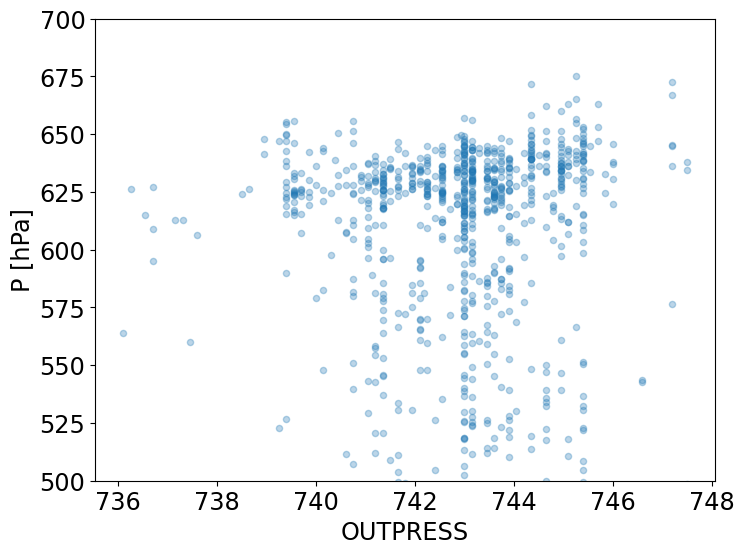

In [81]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
df_spec[cut].plot.scatter(y="P [hPa]",x="OUTPRESS",ax=ax,alpha=0.3)
ax.set_ylim(500,700)
#ax.set_ylim(0,700)

## Apply Quality selection cuts

In [49]:
def getSelectionCutOld(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) 
    return cut

In [50]:
def getSelectionCut(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) 
    return cut

In [51]:
def getSelectionCutNoPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] != "HD185975")
    return cut

In [52]:
def getSelectionCutWithPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] == "HD185975")
    return cut

In [53]:
cut = getSelectionCut(df_spec) 
cut_nopolar = getSelectionCutNoPolar(df_spec) 
cut_nopolar_bright = getSelectionCutNoPolar(df_spec) & (~df_spec["isFaint"])
cut_nopolar_faint = getSelectionCutNoPolar(df_spec) & (df_spec["isFaint"])
cut_wthpolar = getSelectionCutWithPolar(df_spec)

In [54]:
df_spec_sel = df_spec[cut]
df_spec_np = df_spec[cut_nopolar] 
df_spec_np_b = df_spec[cut_nopolar_bright]
df_spec_np_f = df_spec[cut_nopolar_faint]
df_spec_wp = df_spec[cut_wthpolar]

In [55]:
print("Total number of Spectra          : ",len(df_spec))
print("Number of selected Spectra       : ",len(df_spec_sel))
print("Number of selected Polars        : ",len(df_spec_wp))
print("Number of selected Non-Polars    : ",len(df_spec_np))
print("Number of selected Non-Polars Bright : ",len(df_spec_np_b))
print("Number of selected Non-Polars Faint  : ",len(df_spec_np_f))

Total number of Spectra          :  2590
Number of selected Spectra       :  1057
Number of selected Polars        :  489
Number of selected Non-Polars    :  568
Number of selected Non-Polars Bright :  484
Number of selected Non-Polars Faint  :  84


In [56]:
df_spec_sel.reset_index(drop=True,inplace=True)
df_spec_np.reset_index(drop=True,inplace=True)
df_spec_wp.reset_index(drop=True,inplace=True) 
df_spec_np_b.reset_index(drop=True,inplace=True)
df_spec_np_f.reset_index(drop=True,inplace=True)

In [57]:
#List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
print("Polar            :",len(df_spec_wp["TARGET"].unique()),"\t", df_spec_wp["TARGET"].unique()) 
print("Non Polar        :",len(df_spec_np["TARGET"].unique()),"\t" ,df_spec_np["TARGET"].unique())
print("Non Polar Bright :",len(df_spec_np_b["TARGET"].unique()),"\t" ,df_spec_np_b["TARGET"].unique())
print("Non Polar Faint  :",len(df_spec_np_f["TARGET"].unique()),"\t",df_spec_np_f["TARGET"].unique())

Polar            : 1 	 ['HD185975']
Non Polar        : 6 	 ['HD205905' 'HD2811' 'HD38666' 'HD111980' 'HD146233' 'HD160617']
Non Polar Bright : 4 	 ['HD205905' 'HD2811' 'HD38666' 'HD146233']
Non Polar Faint  : 2 	 ['HD111980' 'HD160617']


## Recompute night boundaries

In [58]:
#dn = GetNightBoundariesDict(df_spec_sel)

## Plot all data

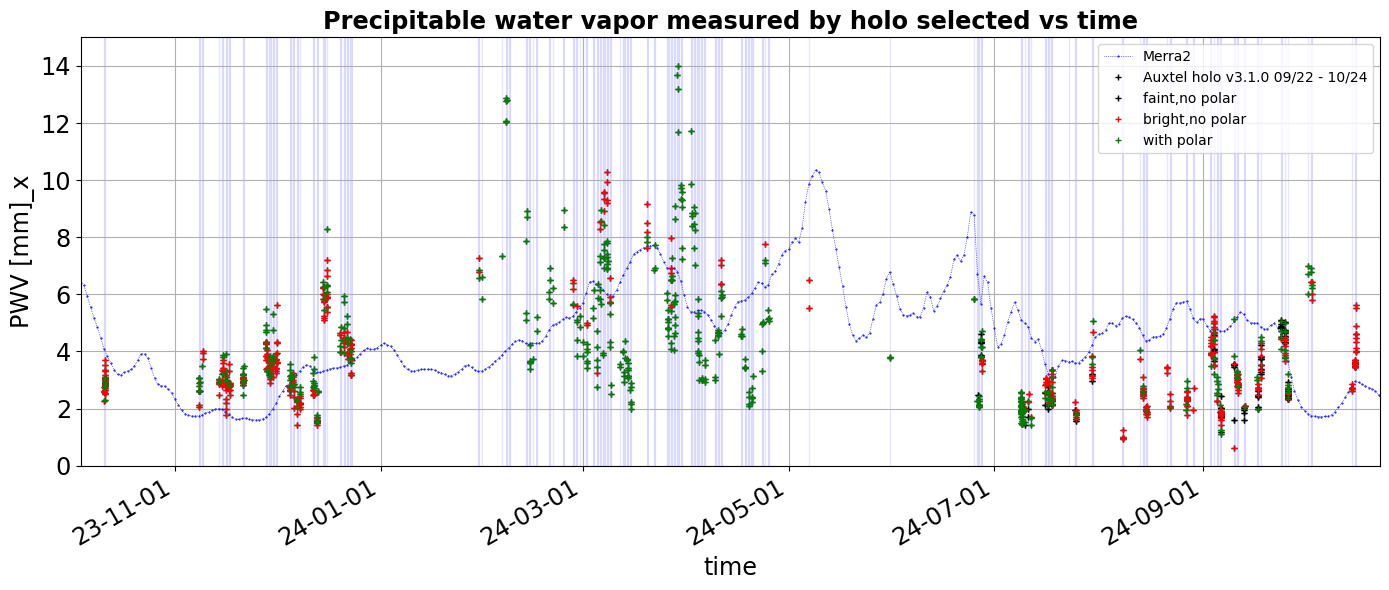

In [59]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TQV",ax=ax,marker=".",c="b",lw=0.5,ms=1,ls=":",label="Merra2",legend=leg)     
    


df_spec_sel.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="k",lw=0.0,grid=True,label=tag,legend=leg,ms=5,alpha=1.0)
df_spec_np_f.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="k",lw=0.0,grid=True,label="faint,no polar",legend=leg,ms=5,alpha=1)
df_spec_np_b.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=1)
#df_spec_np.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
df_spec_wp.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=1)
ax.set_ylabel("PWV [mm]_x")
ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Precipitable water vapor measured by holo selected vs time",fontweight="bold")
ax.legend(loc="upper right")

for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
 


ax.set_ylim(0.,15.)
ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/pwvholoM2_allpoints_allnights_wthcuts"+figtype
plt.savefig(figname)
plt.show()

Text(0, 0.5, 'PWV (mm)')

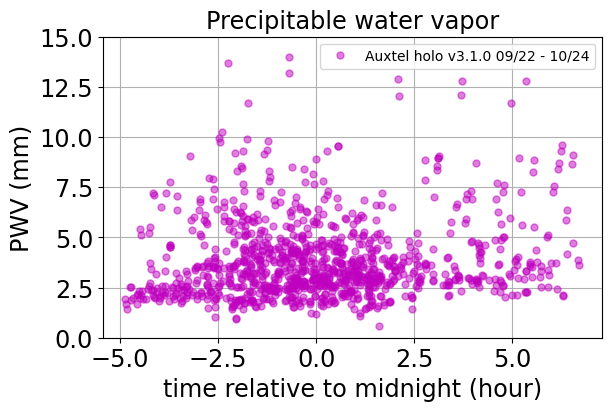

In [60]:
fig,axs = plt.subplots(1,1,figsize=(6,4),layout='constrained')
ax  = axs
leg=ax.get_legend()
#df_spec_np_b.plot(x="dt_midnight",y="PWV [mm]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=0.2)
#df_sel.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label=tag,legend=leg,ms=5,alpha=0.5)
df_spec_sel.plot(x="dt_midnight",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label=tag,legend=leg,ms=5,alpha=0.5)
#df_spec_wp.plot(x="dt_midnight",y="PWV [mm]_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylim(0.,15.)
ax.legend()
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Precipitable water vapor")
ax.set_ylabel("PWV (mm)")

Text(0, 0.5, 'PWV_y (mm)')

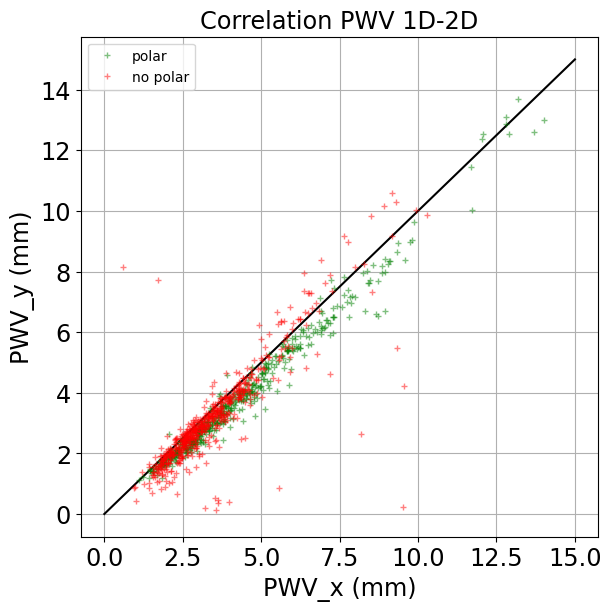

In [61]:
fig,axs = plt.subplots(1,1,figsize=(6,6),layout='constrained')
ax  = axs
leg=ax.get_legend()
ax.plot([0.,15.],[0.,15.],"k-")
df_spec_wp.plot(x="PWV [mm]_x",y="PWV [mm]_y",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="polar",legend=leg,ms=5,alpha=0.5)
df_spec_np.plot(x="PWV [mm]_x",y="PWV [mm]_y",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)

ax.legend()
ax.set_xlabel("PWV_x (mm)")
ax.set_title("Correlation PWV 1D-2D")
ax.set_ylabel("PWV_y (mm)")

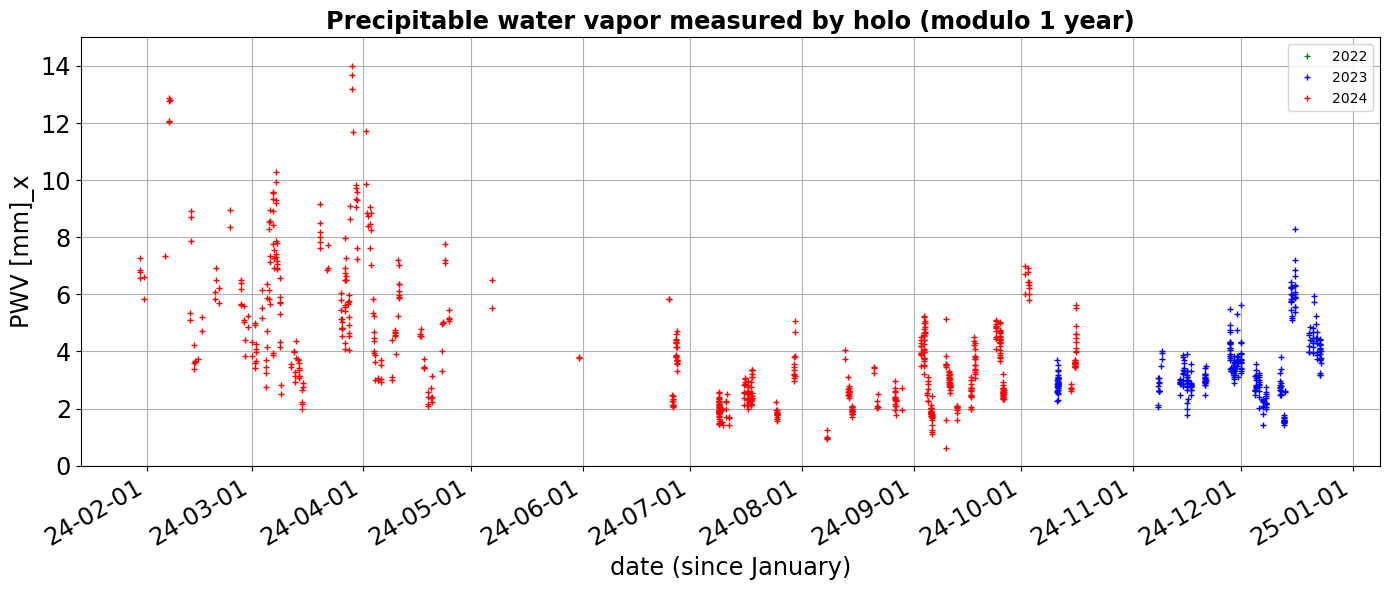

In [62]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")

fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()

#ax.set_xlim(TMIN,TMAX) 
#df_m.plot(x="Time",y="TQV",ax=ax,marker=".",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)     
    
df_spec_sel[df_spec_sel.Year==2022].plot(x="Time_january",y="PWV [mm]_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="2022",legend=leg,ms=5,alpha=1.)
df_spec_sel[df_spec_sel.Year==2023].plot(x="Time_january",y="PWV [mm]_x",ax=ax,marker='+',c="b",lw=0.0,grid=True,label="2023",legend=leg,ms=5,alpha=1.)
df_spec_sel[df_spec_sel.Year==2024].plot(x="Time_january",y="PWV [mm]_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="2024",legend=leg,ms=5,alpha=1.)
#df_spec_np_f.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="grey",lw=0.0,grid=True,label="faint,no polar",legend=leg,ms=5,alpha=0.2)
#df_spec_np_b.plot(x="Time_january",y="PWV [mm]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=0.2)
#df_spec_np.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
#df_spec_wp.plot(x="Time_january",y="PWV [mm]_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylabel("PWV [mm]_x")
ax.set_xlabel("date (since January)")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Precipitable water vapor measured by holo (modulo 1 year)",fontweight="bold")
ax.legend()

#for key, tt in dn.items():
#    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
 


ax.set_ylim(0.,15.)
#ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/pwvholoM2_allpoints_allnights_modulo1year"+figtype
plt.savefig(figname)
plt.show()

## Plot night by night

In [63]:
def ComputeRepeatability(df):
    """
    Compute Repeatability of PWV for Spectrogram and and Spectrum
    
    """
    N = len(df)
    dfout = pd.DataFrame(index=df.index,columns = ["nightObs","dt","dt_rep","dPWVx_rep","dPWVy_rep","targflag_rep","Npoints"])
    dfout["targflag_rep"].astype(bool)
    #dfout["Npoints"].astype(int)
    
    target_old = "No"
    time_old = 0.
    pwvx_old = 0.
    pwvy_old = 0.
    
    for index in range(N):
        
        nightObs =  df.iloc[index]["nightObs"]
        
        if index ==0:
            dt0 = df.iloc[index]["dt"]
            dfout.iloc[index] = [ nightObs,dt0, 0., 0., 0., False,N]
        else:
            target_new = df.iloc[index]["TARGET"]
            time_new = df.iloc[index]["dt"]
            pwvx_new = df.iloc[index]["PWV [mm]_x"]
            pwvy_new = df.iloc[index]["PWV [mm]_y"]
            
            flag_target = (target_new == target_old)
            dPWVx_rep = pwvx_new - pwvx_old
            dPWVy_rep = pwvy_new - pwvy_old
            dt_rep = (time_new-time_old)*3600. # in seconds
            
            dfout.iloc[index] = [ nightObs,time_new, dt_rep, dPWVx_rep, dPWVy_rep, flag_target,N]
        
        target_old = df.iloc[index]["TARGET"]
        time_old = df.iloc[index]["dt"]
        pwvx_old = df.iloc[index]["PWV [mm]_x"]
        pwvy_old = df.iloc[index]["PWV [mm]_y"]
        
    return dfout

In [64]:
all_selected_nights = df_spec_sel["nightObs"].unique()

In [65]:
def funclineres(params, x, y, yerr):
    # Return residual = fit-observed
    return (y-params[0] -params[1]*x)/yerr
def funcline(params,x):
    return params[0] + params[1]*x

In [66]:
def MakeLineFit(df_night_pwv_curve):
    """
    """

    x = df_night_pwv_curve["dt_midnight"].values
    y = df_night_pwv_curve["PWV [mm]_x"].values
    yerr = df_night_pwv_curve["PWV [mm]_err_x"].values
    n = len(y)
        
    #popt, pcov = optimize.curve_fit(f, x, y, [1,-4])
    fit_res = least_squares(funclineres,[5.,0],args = (x,y,yerr))
    popt = fit_res.x 
    npar = len(popt)
    J = fit_res.jac
    cov = np.linalg.inv(J.T.dot(J))
    chi2dof = ((funclineres(popt,x,y,yerr))**2).sum()/(n-npar)
    cov *= chi2dof
    perr = np.sqrt(np.diagonal(cov)) 
    
    xfit = np.linspace(x.min()*0.99,x.max()*1.05)
    yfit = funcline(popt,xfit)
        
    slope = popt[1]
    slope_err = perr[1]

    return x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err

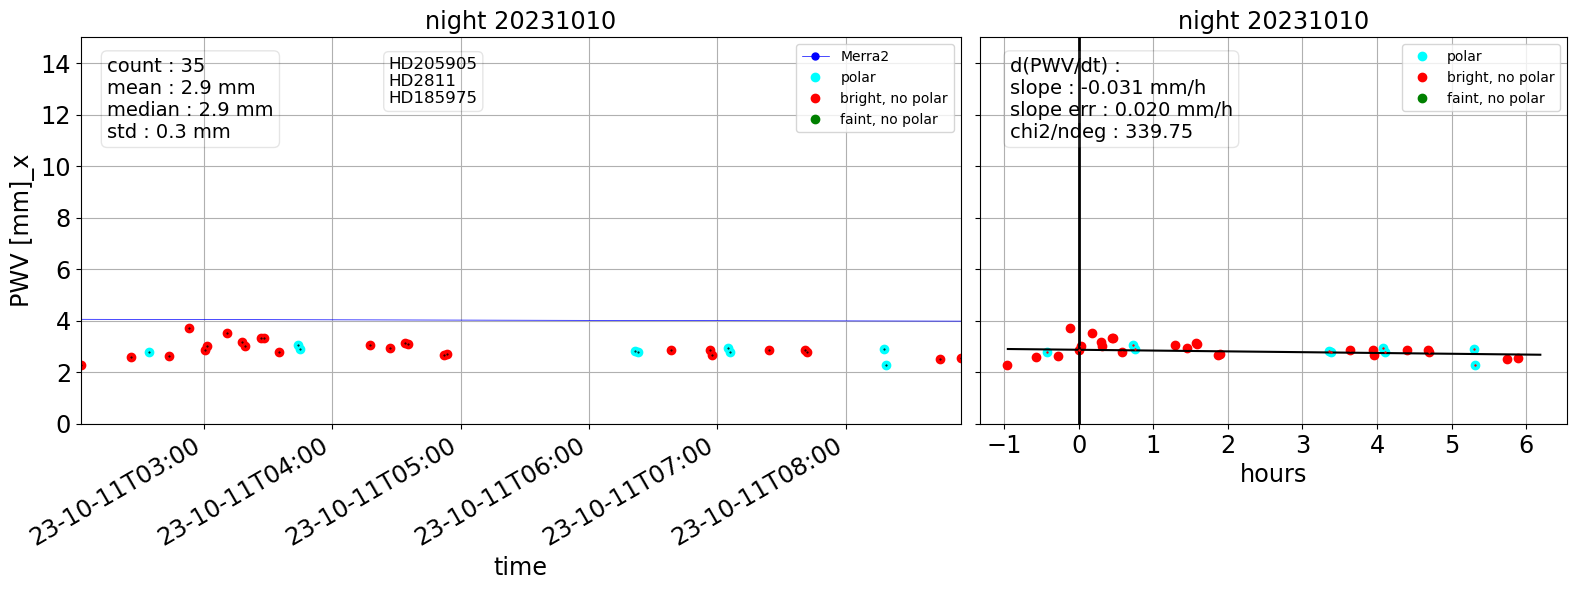

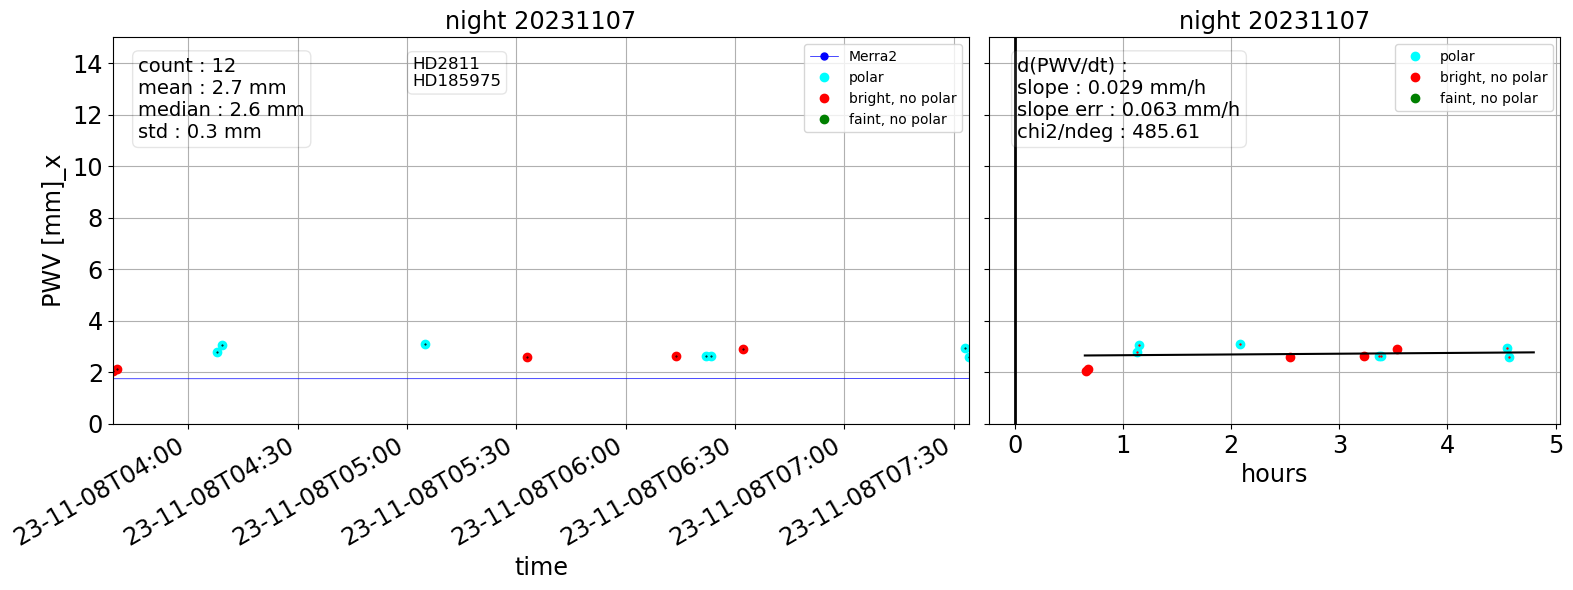

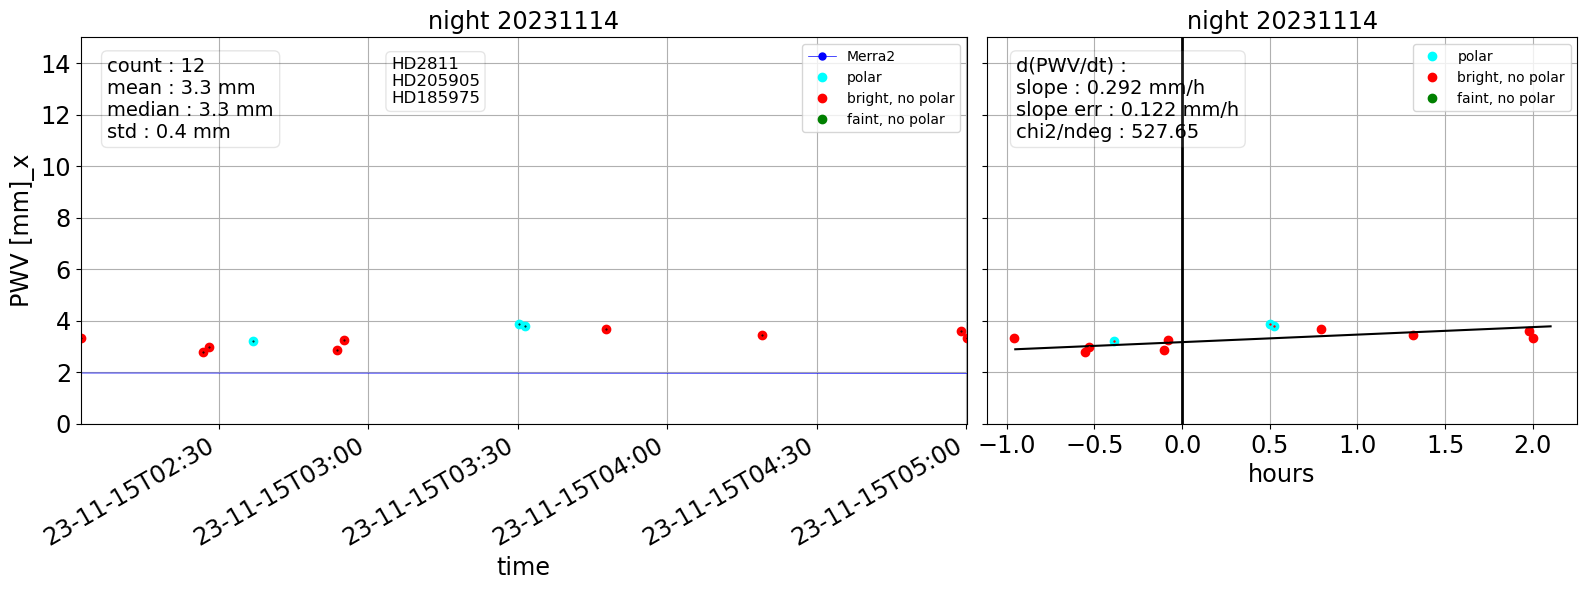

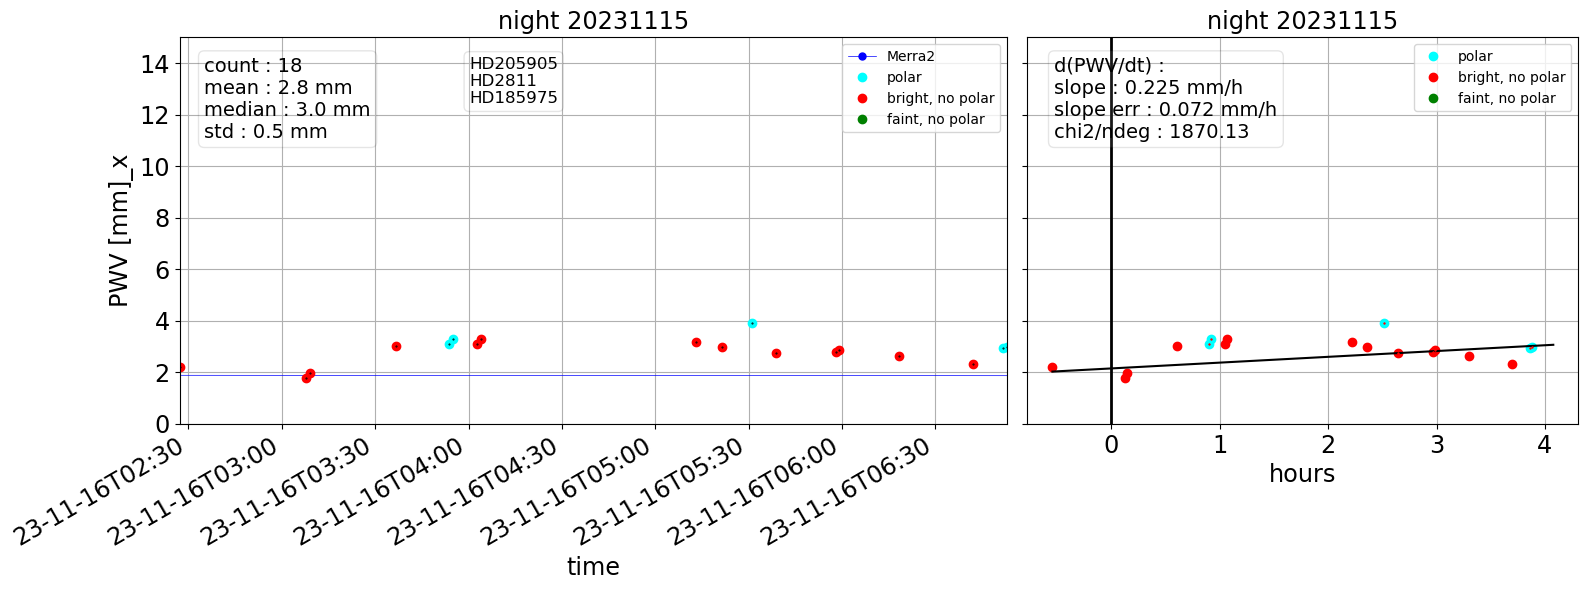

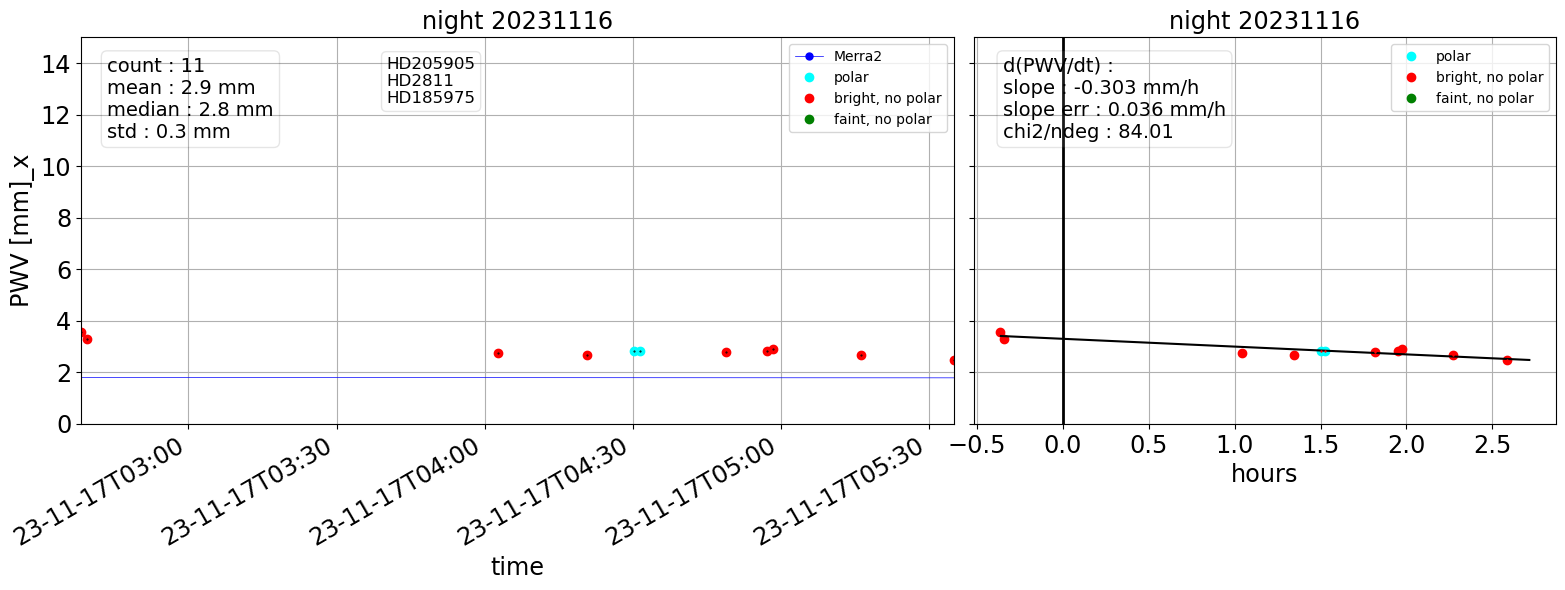

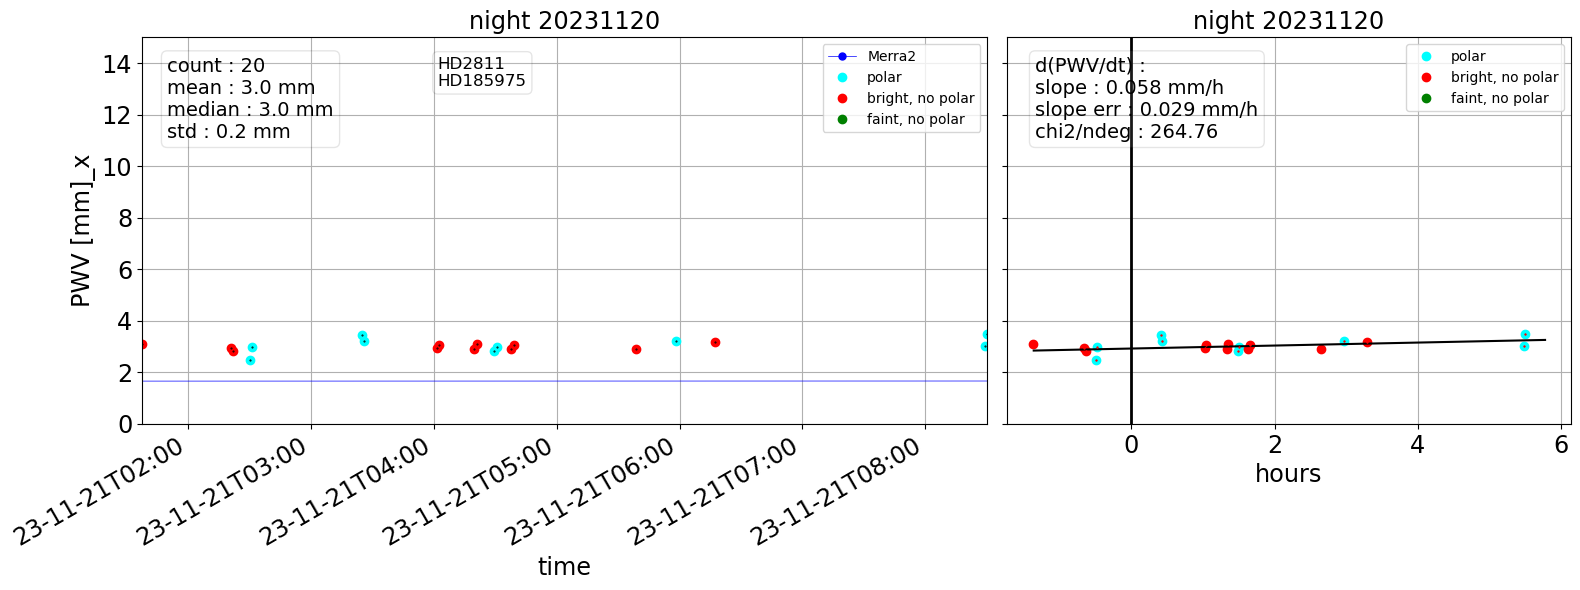

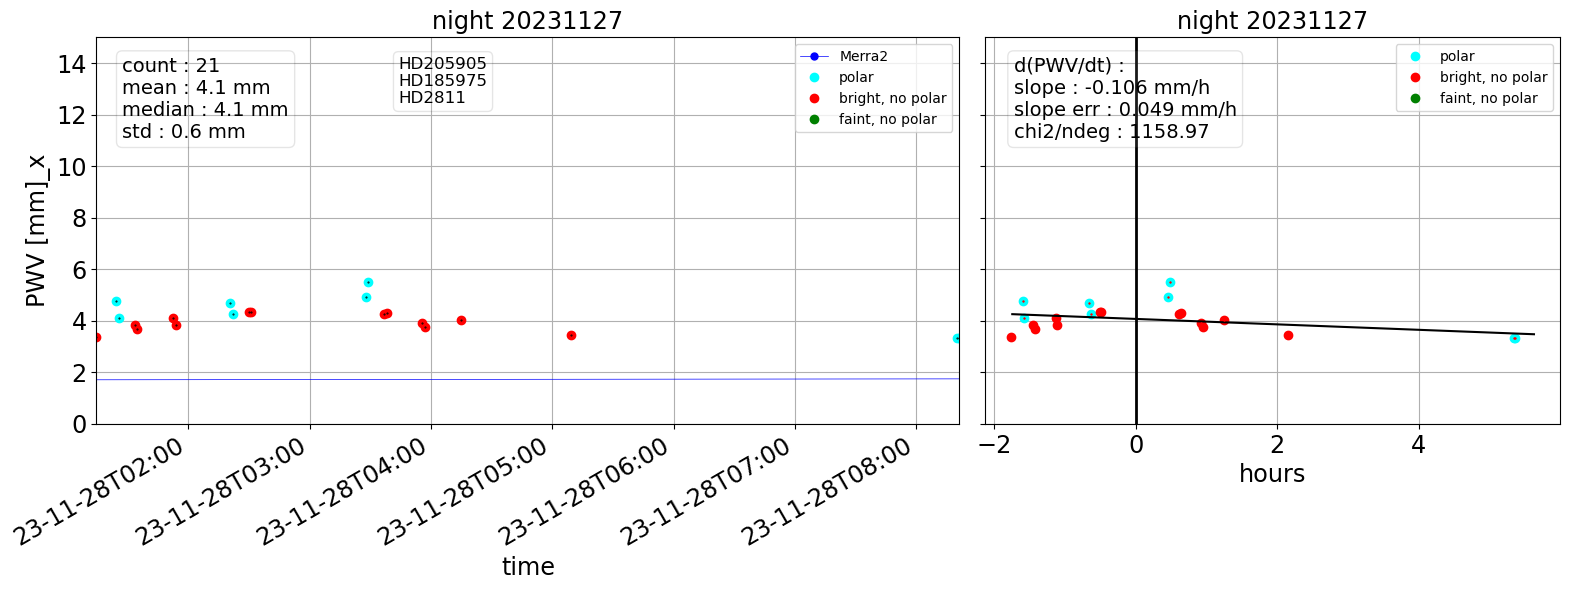

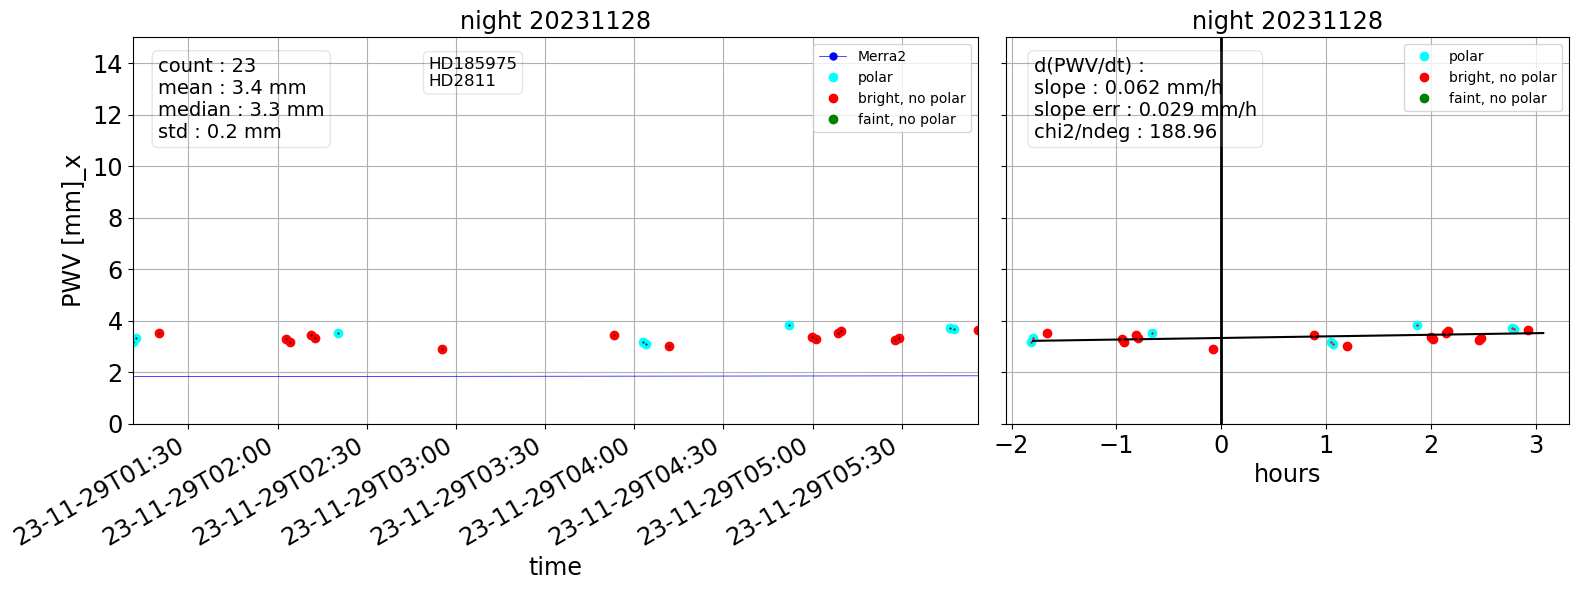

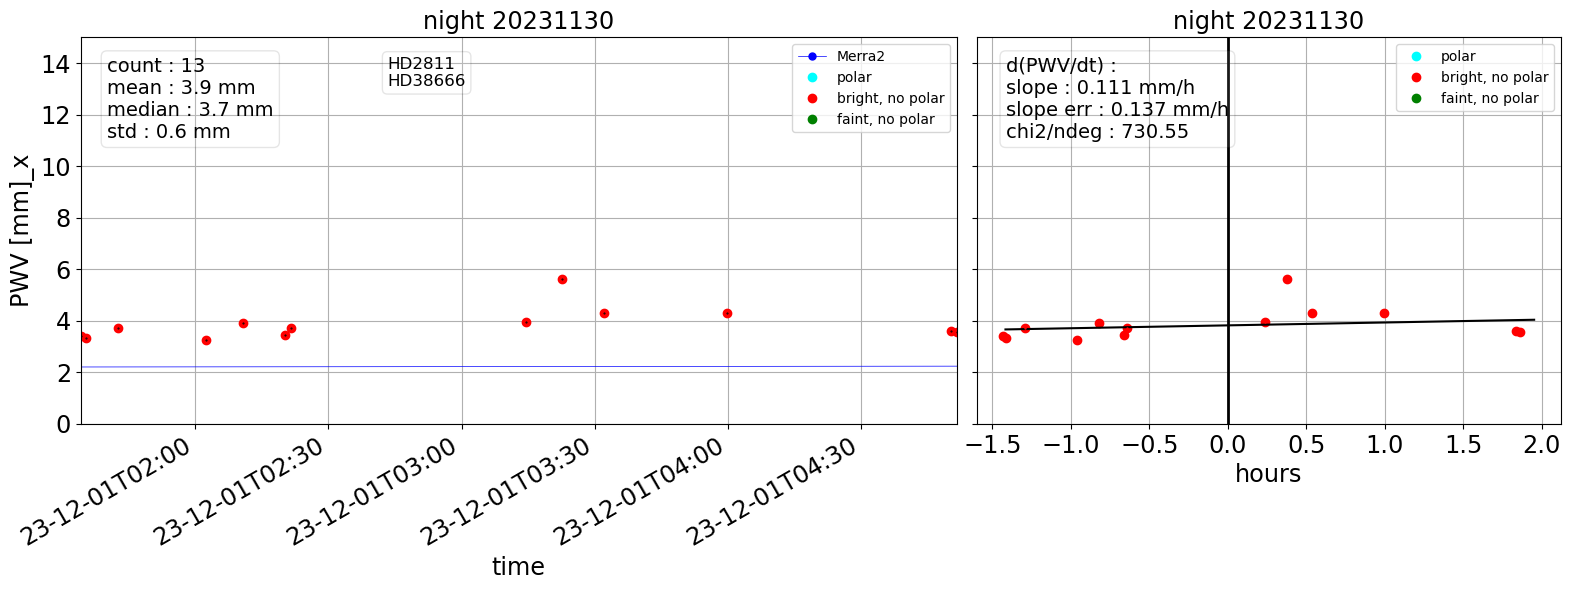

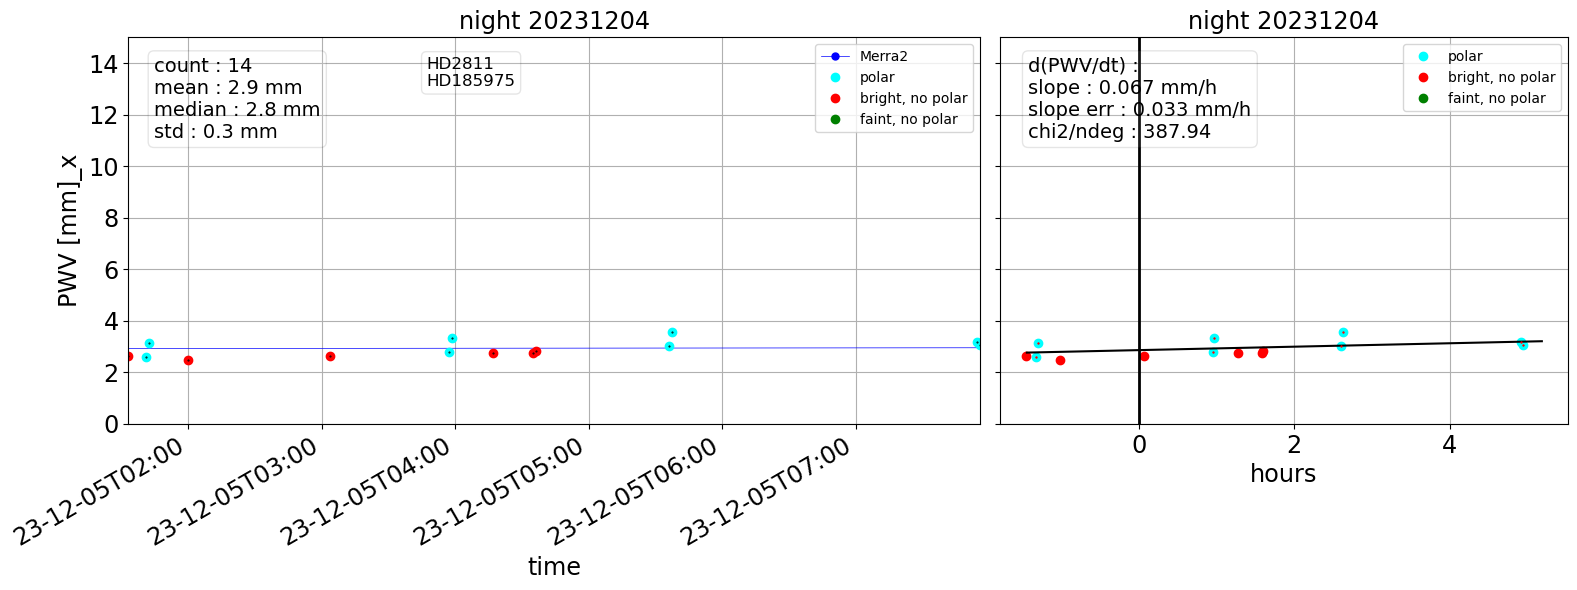

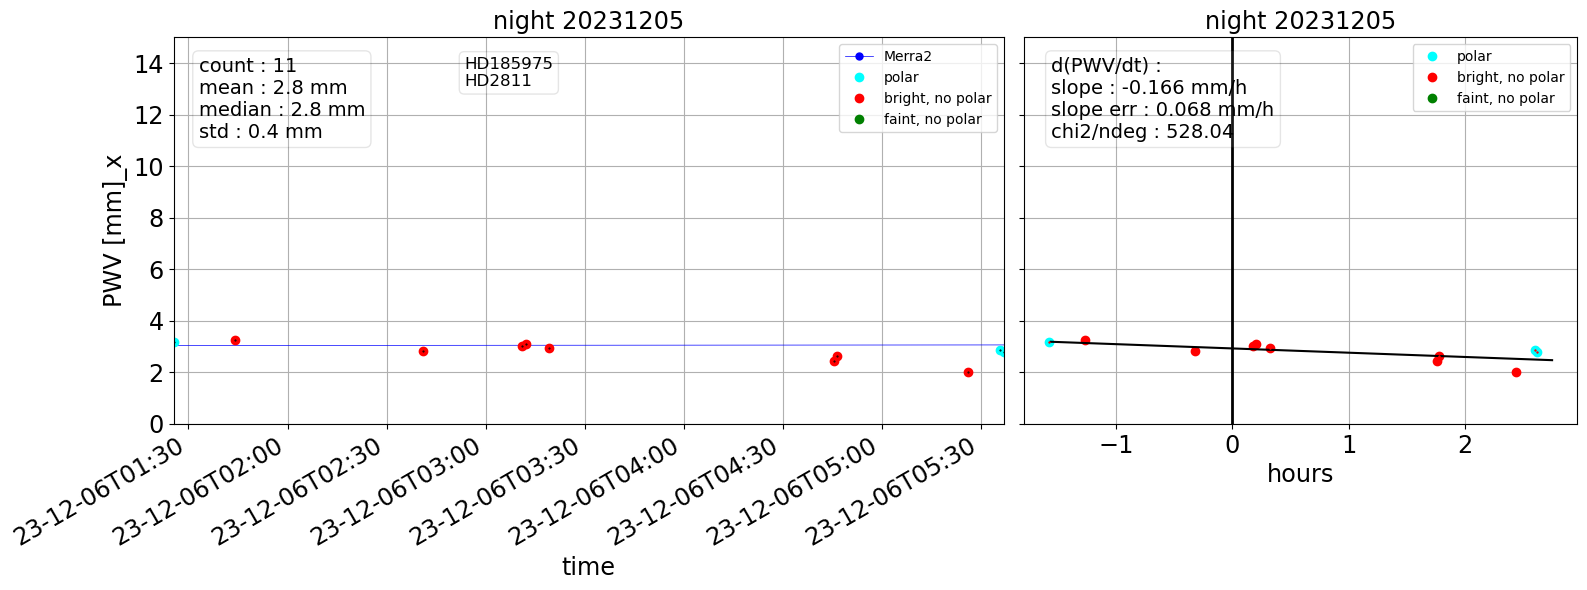

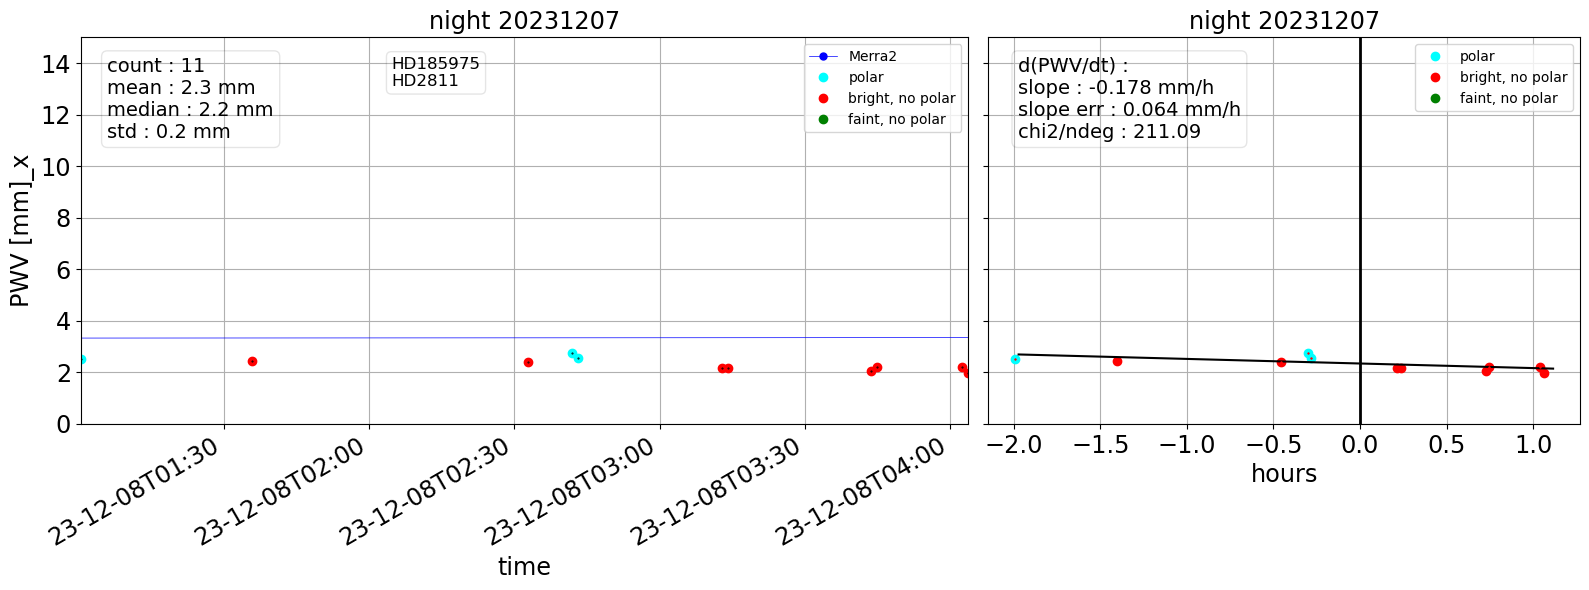

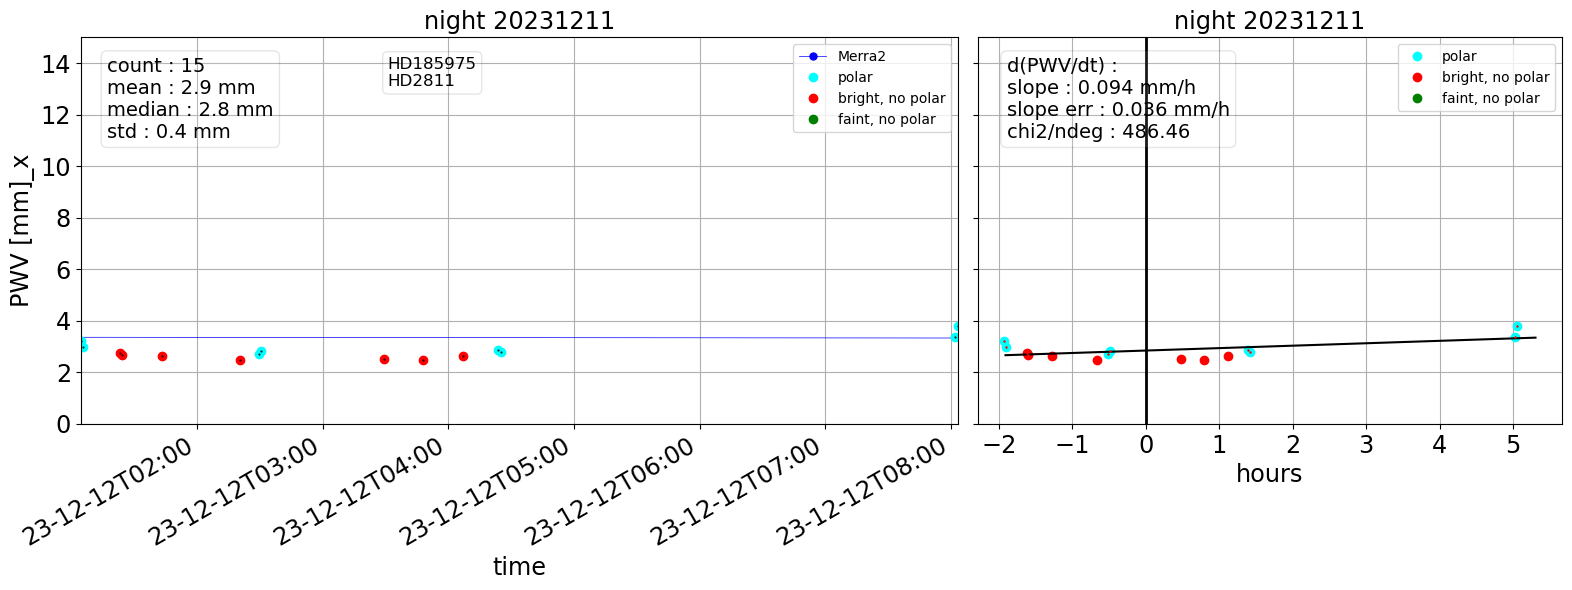

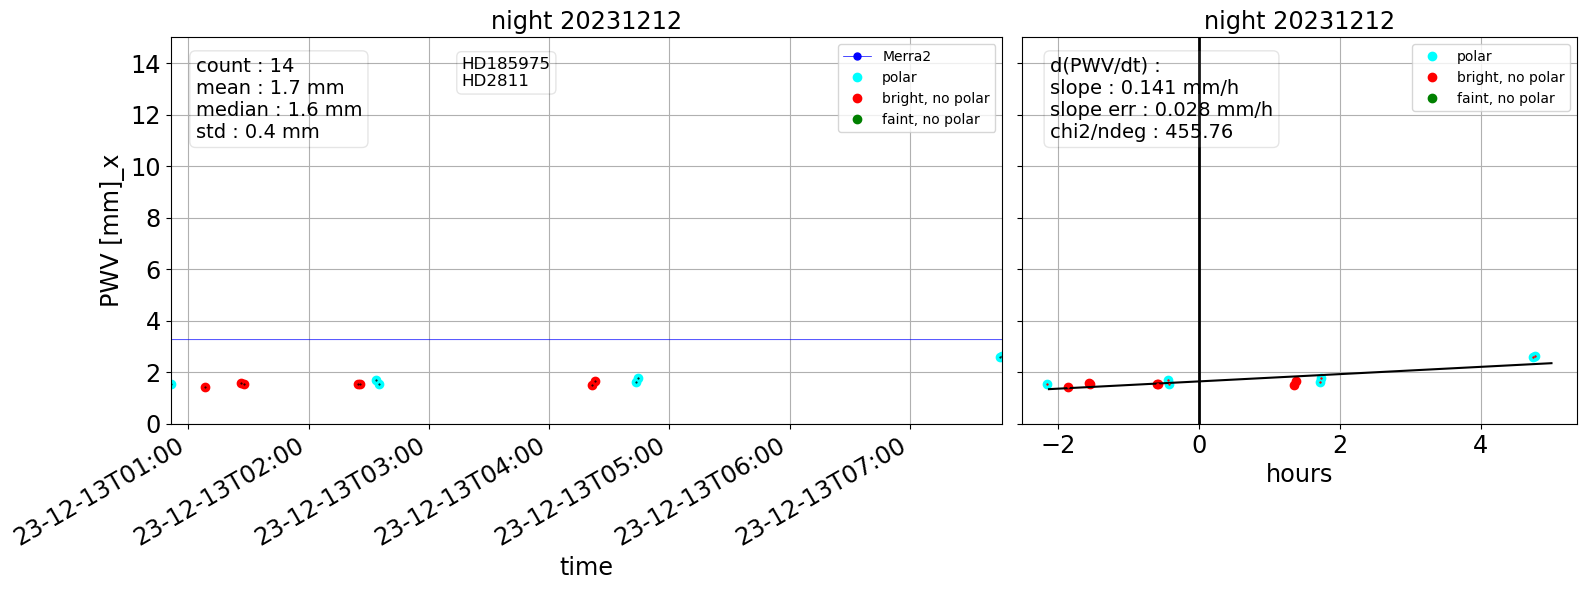

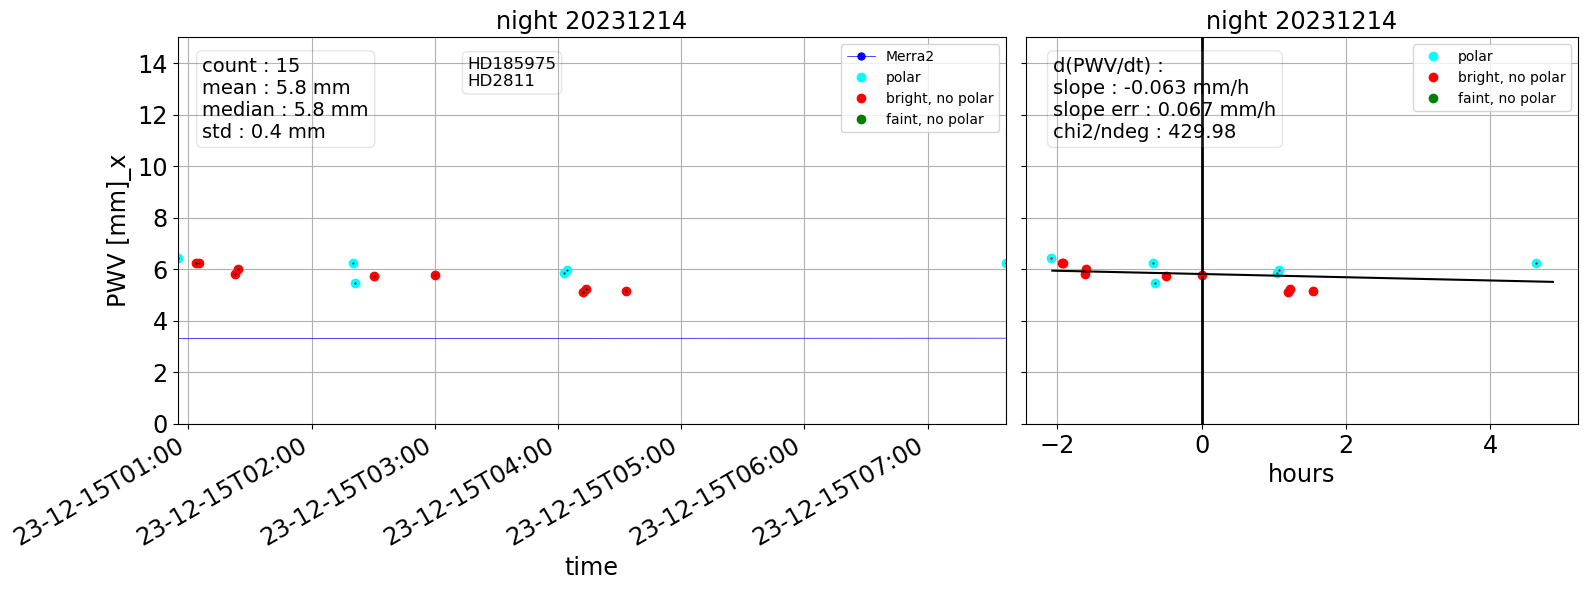

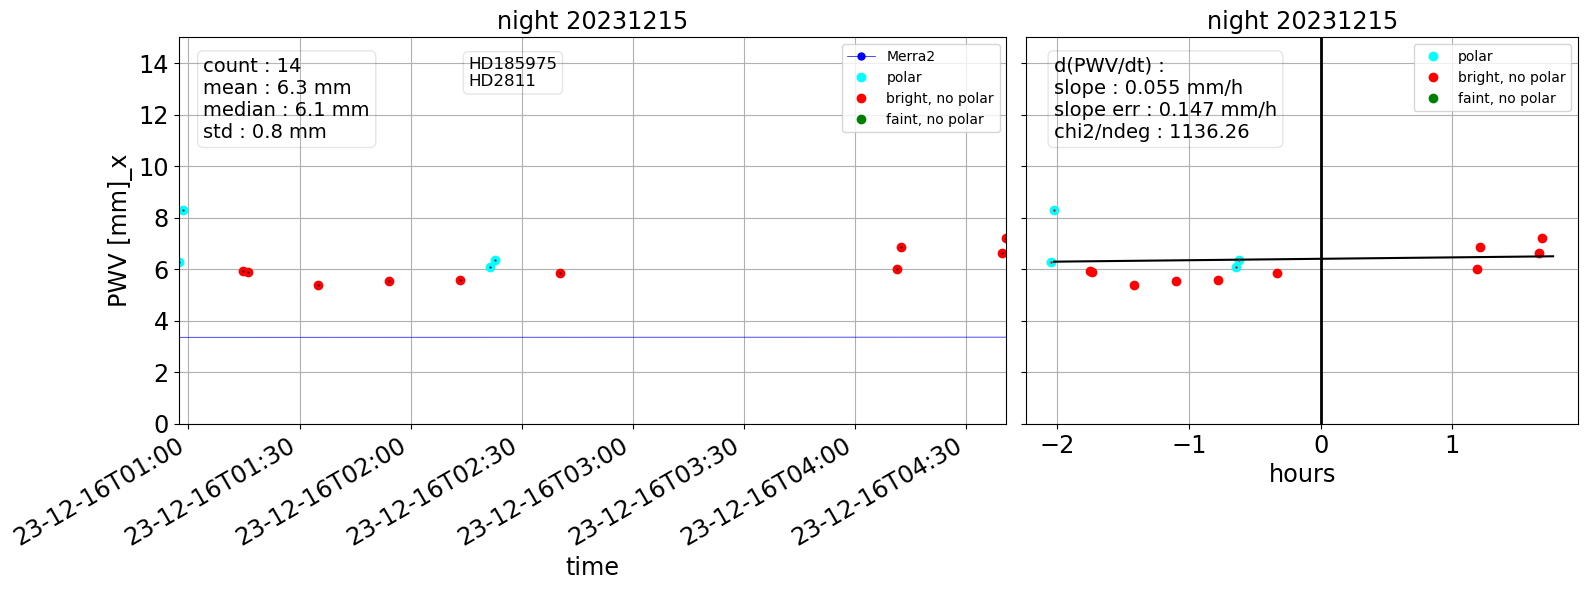

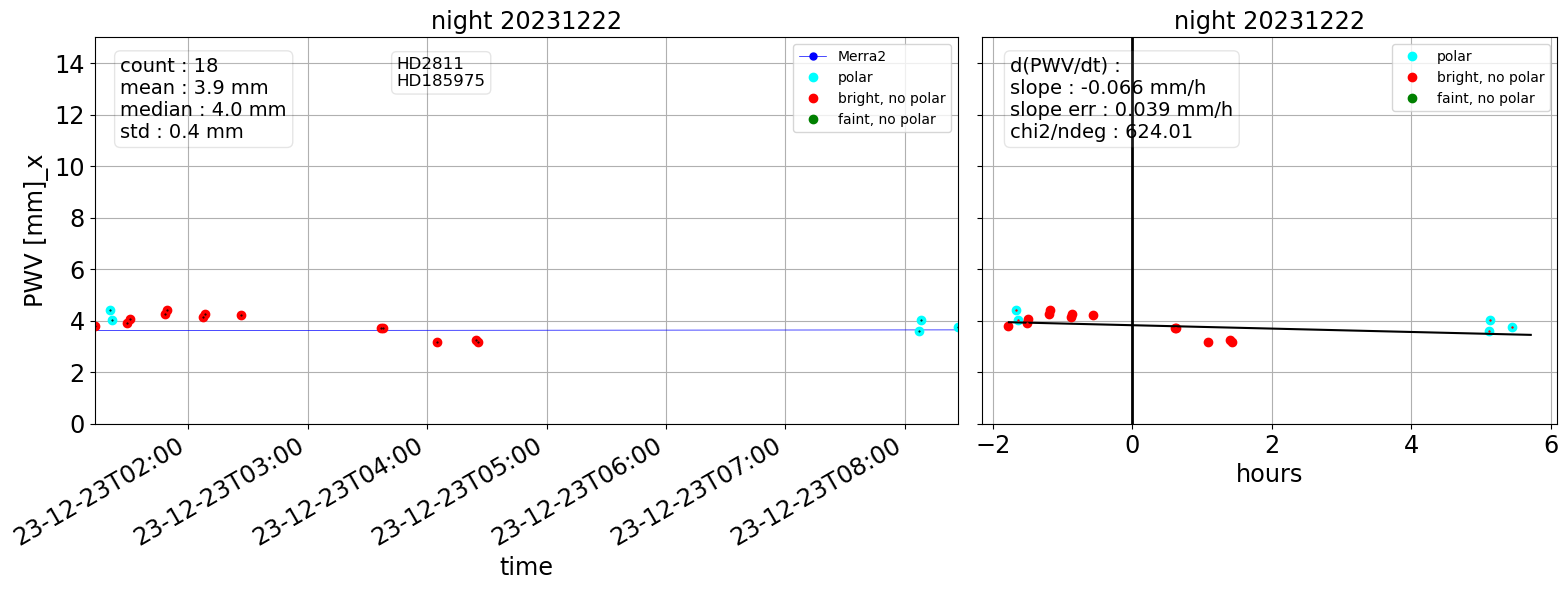

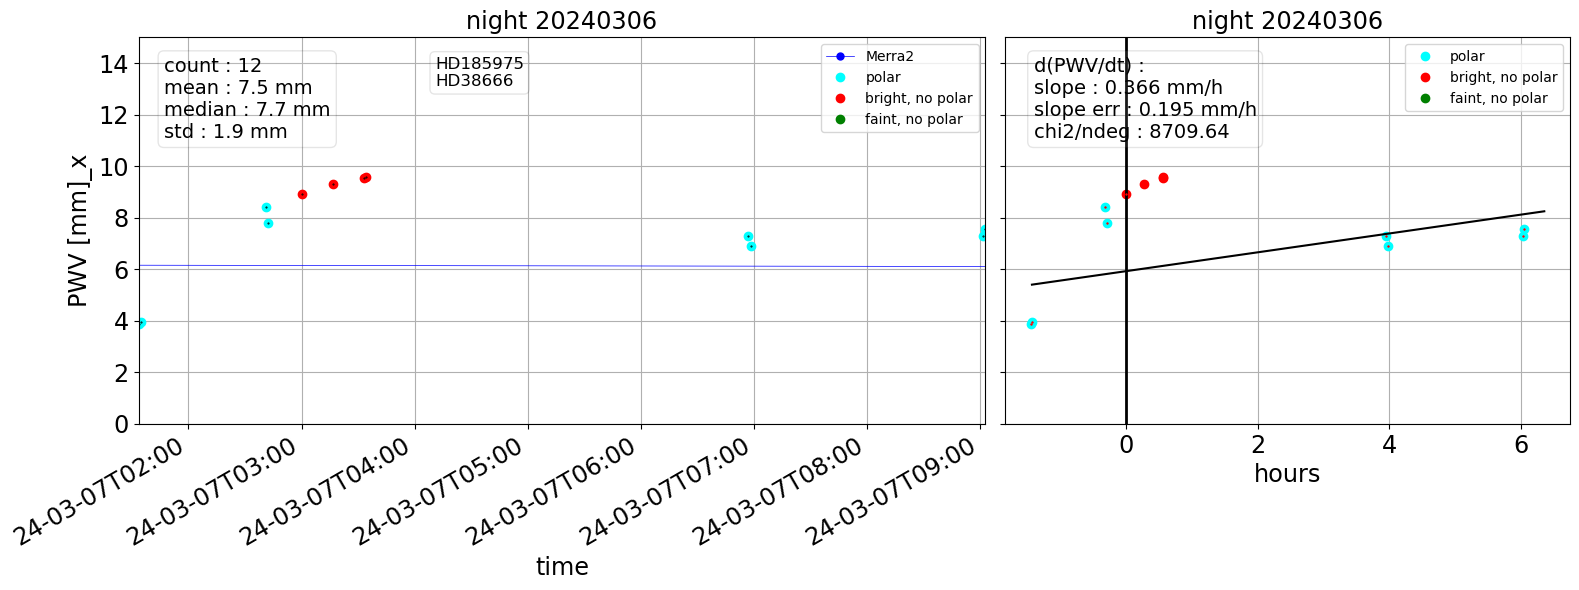

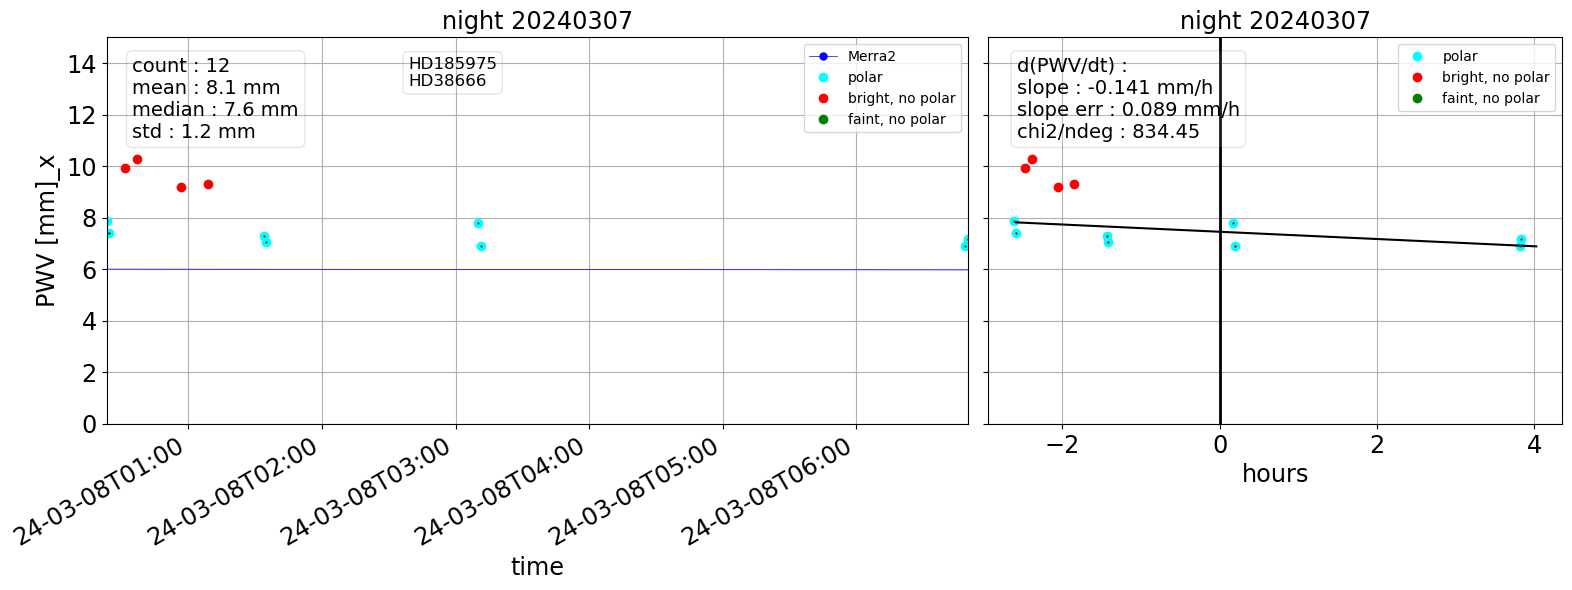

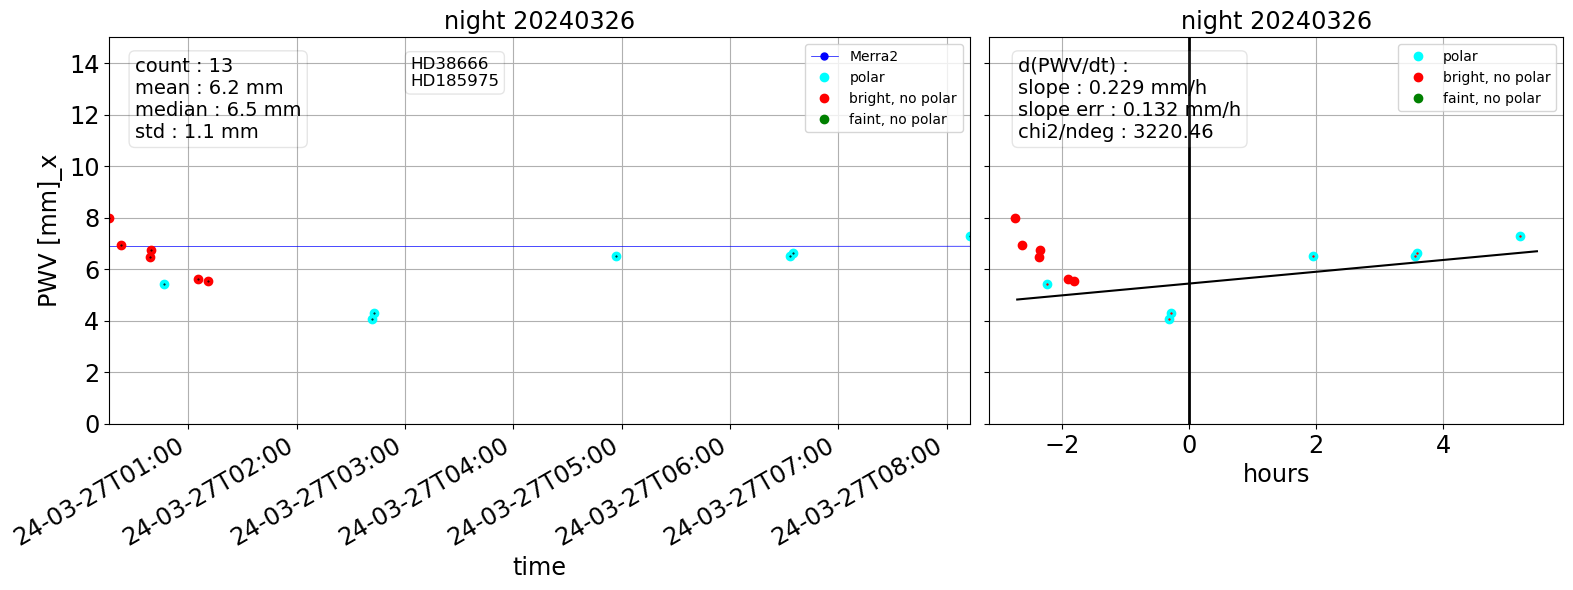

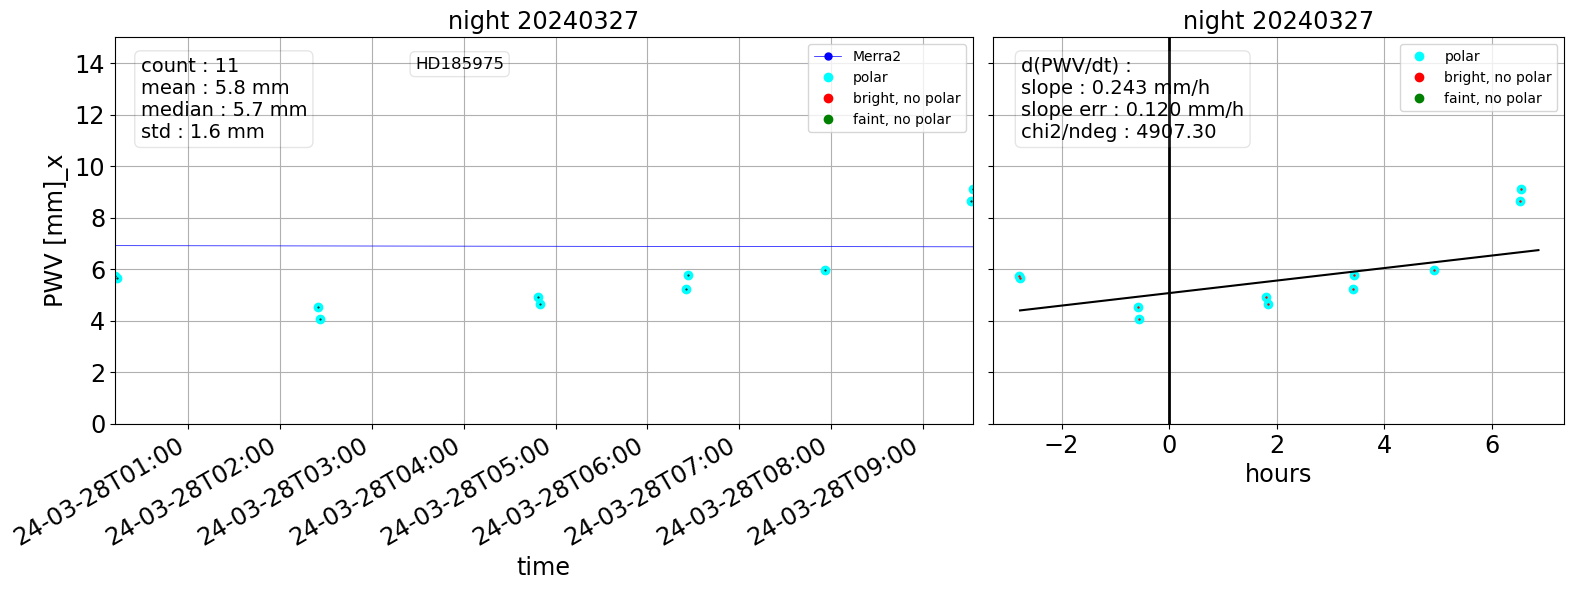

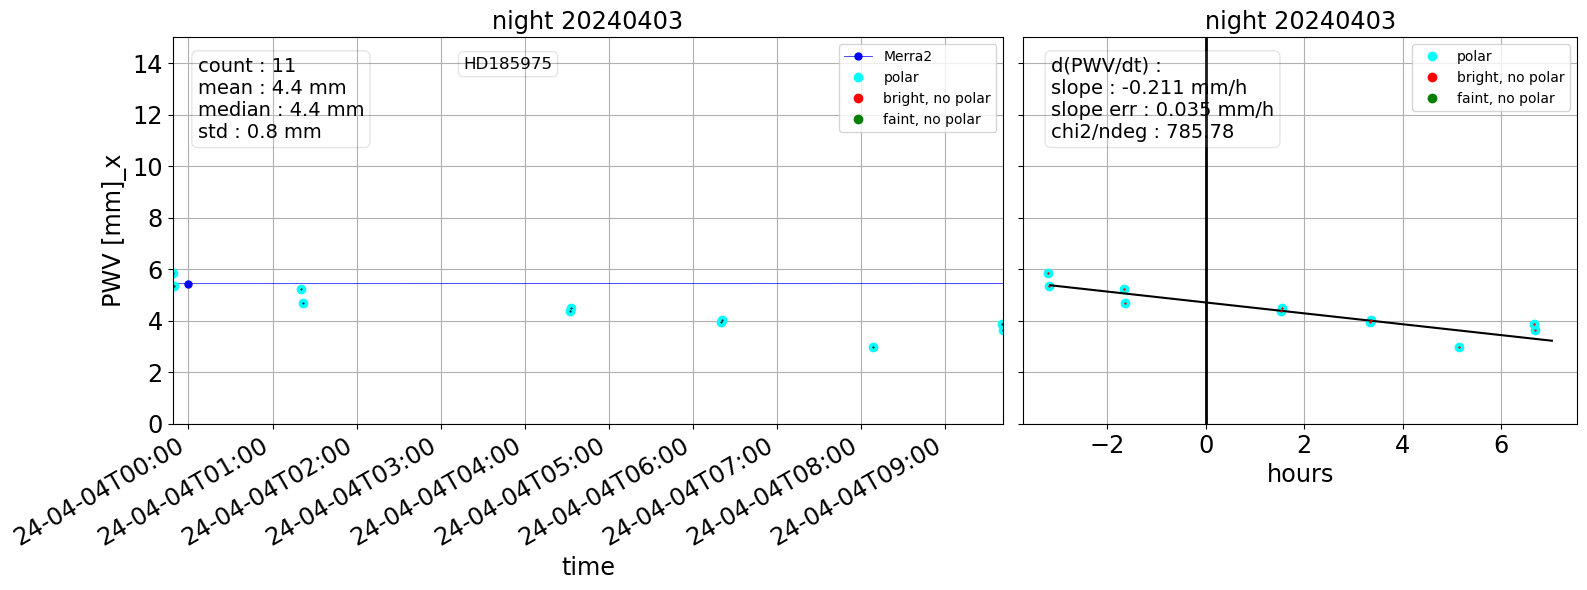

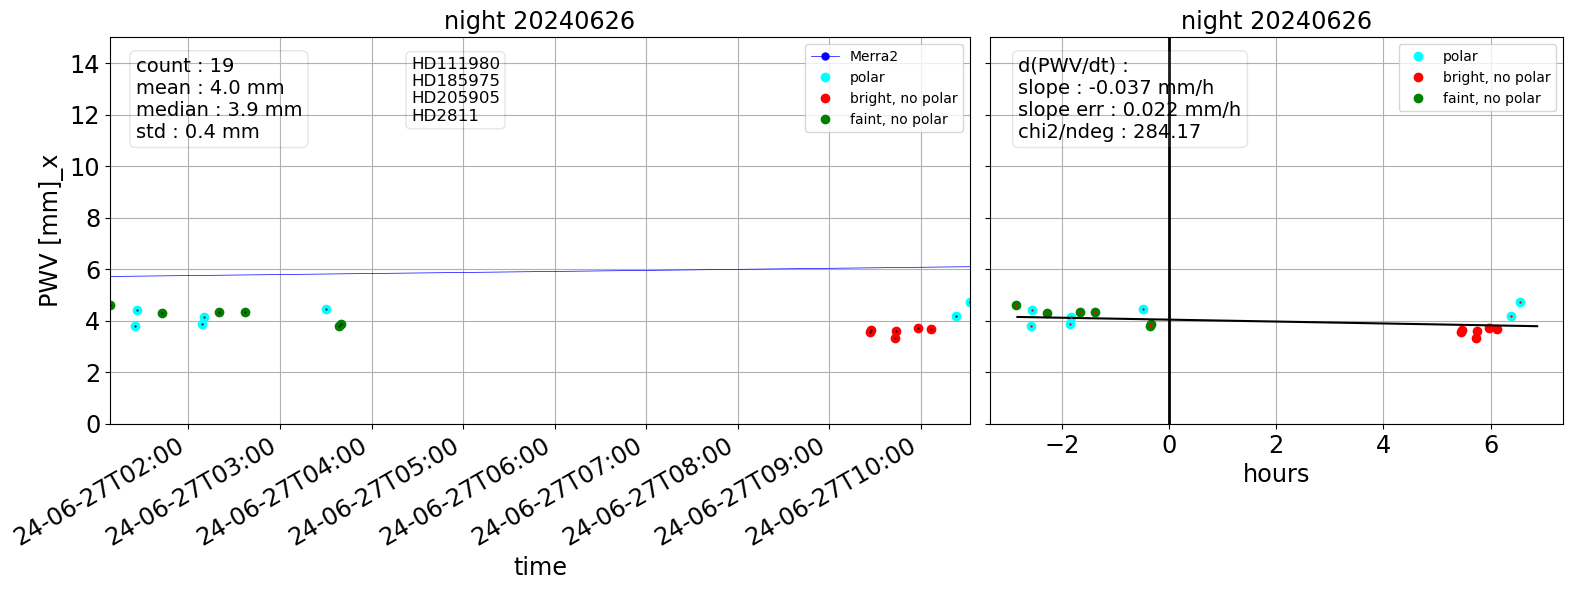

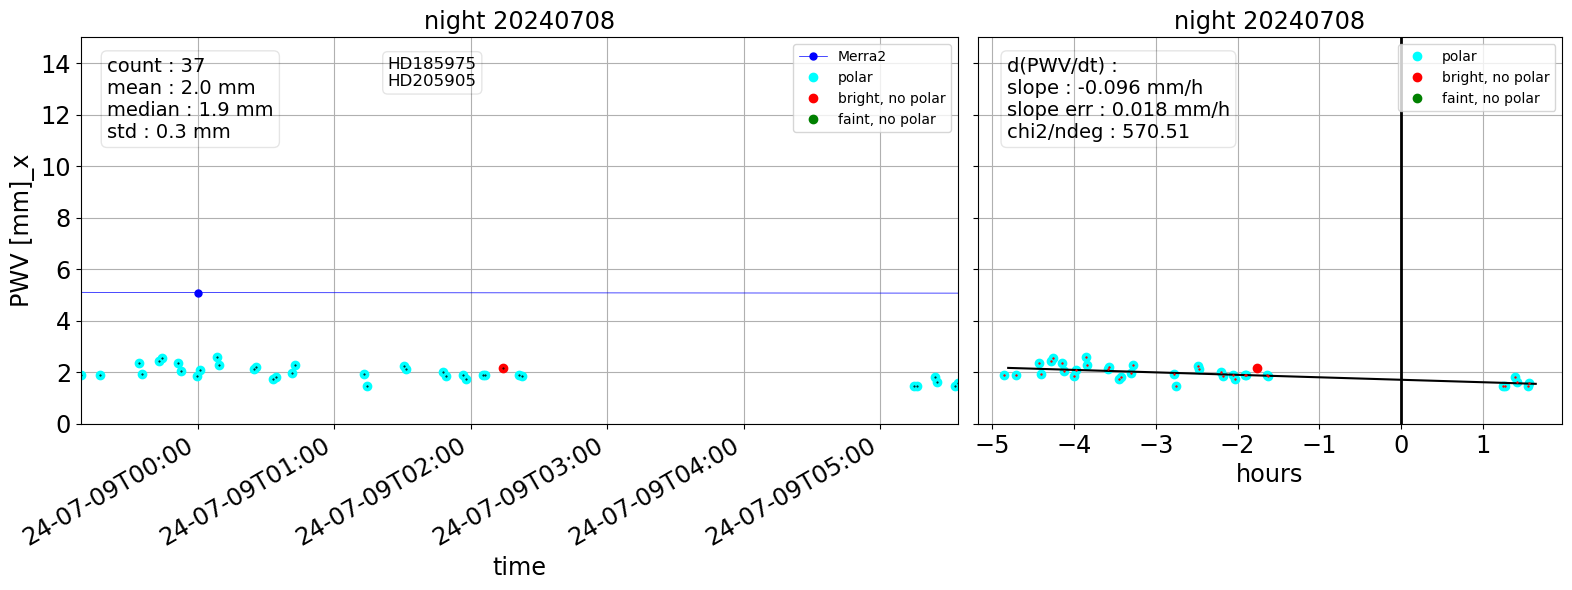

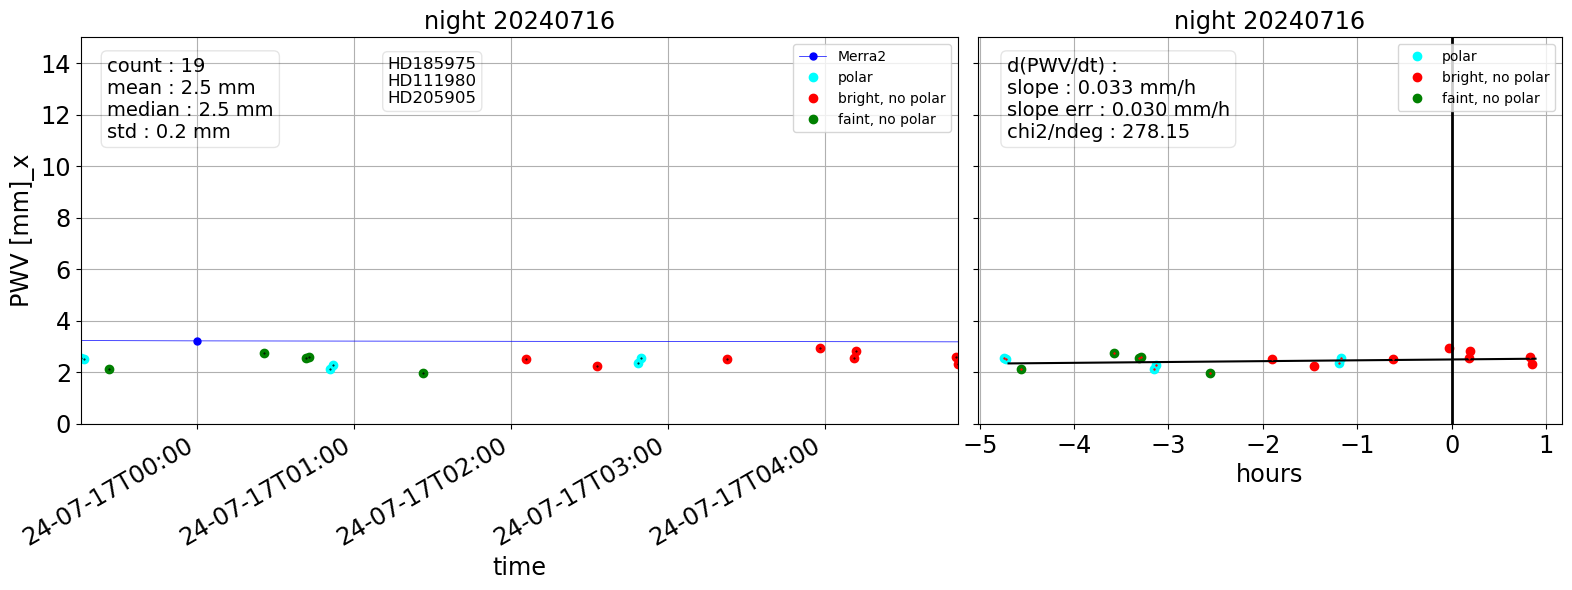

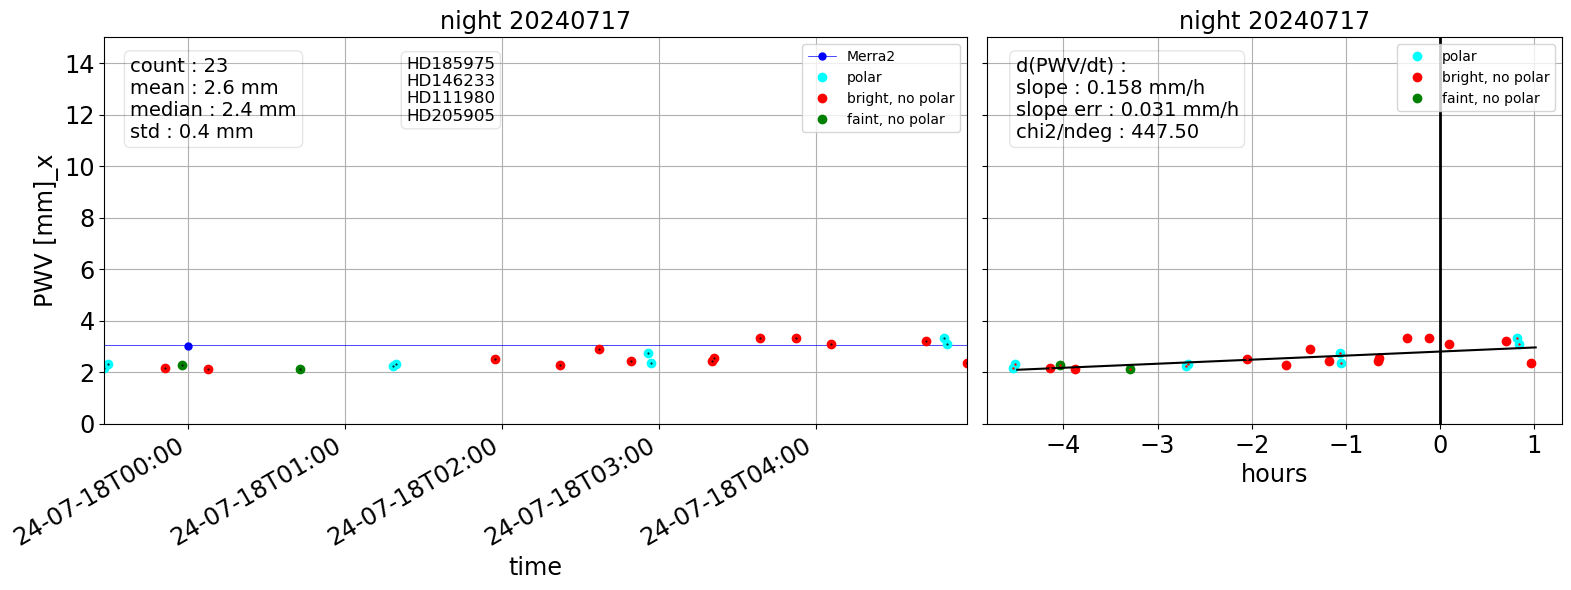

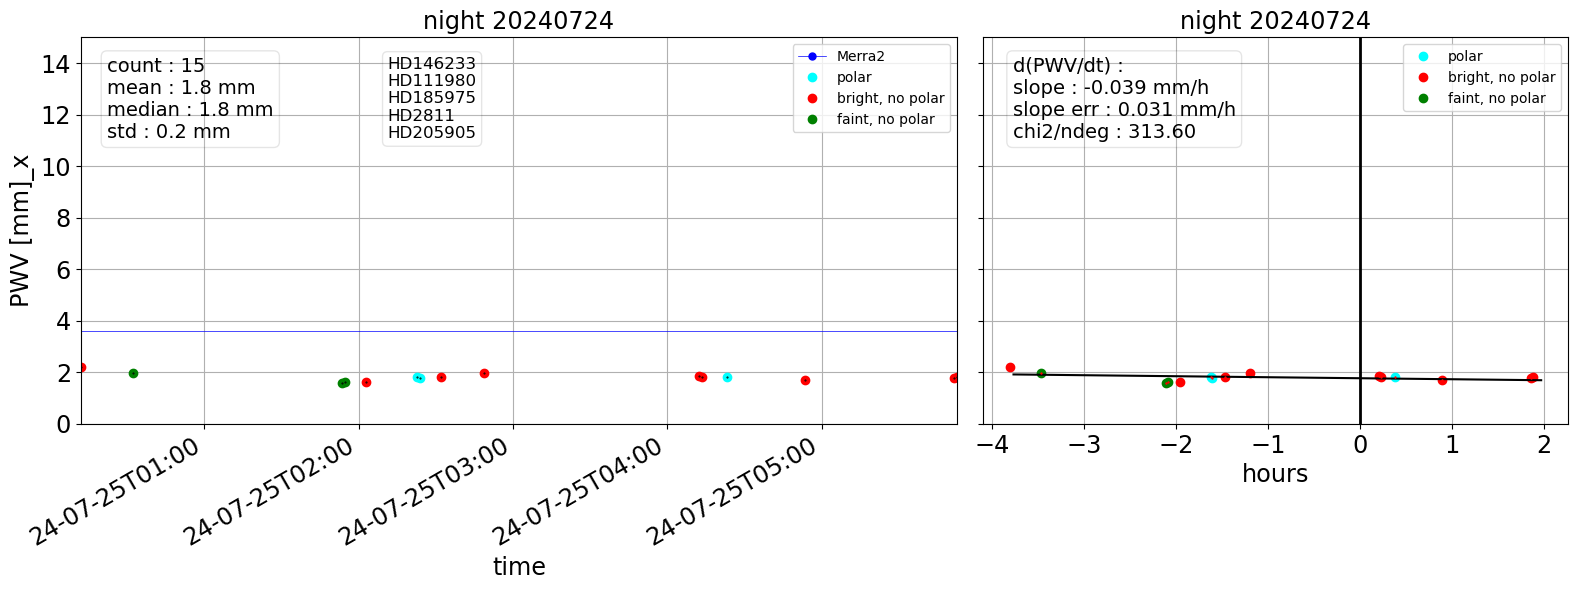

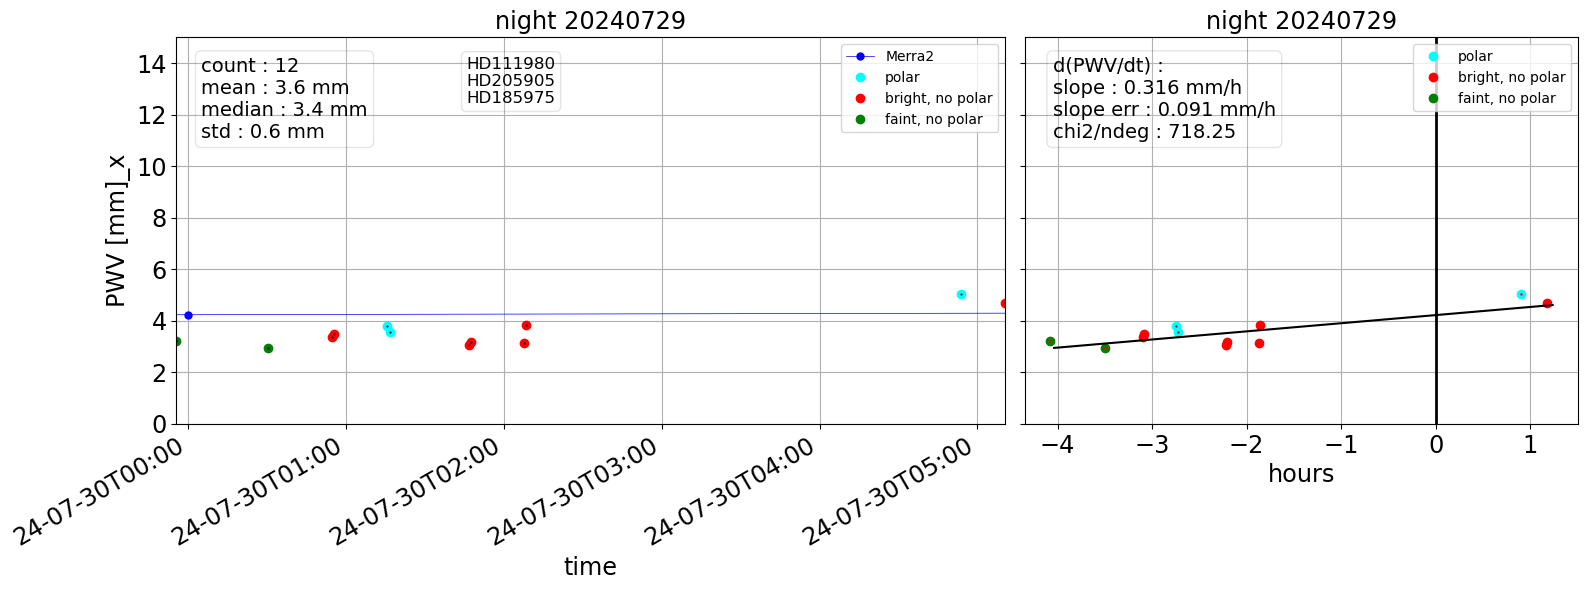

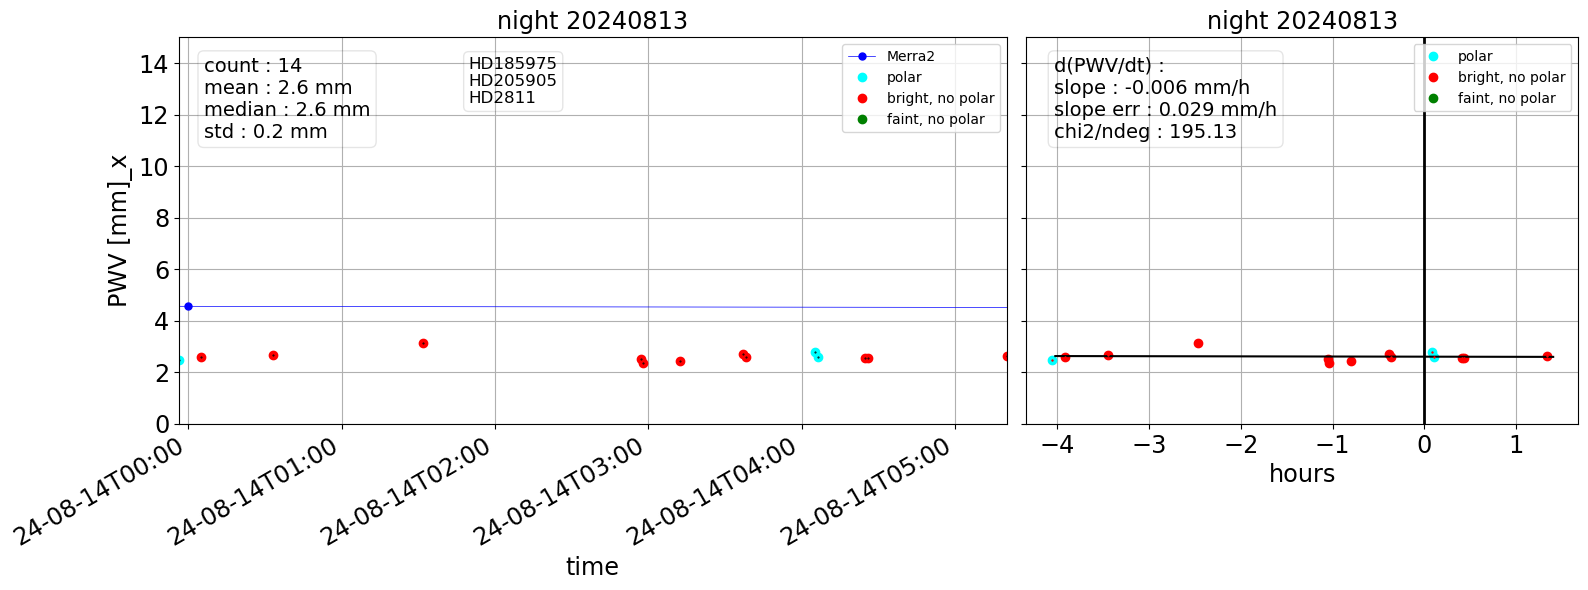

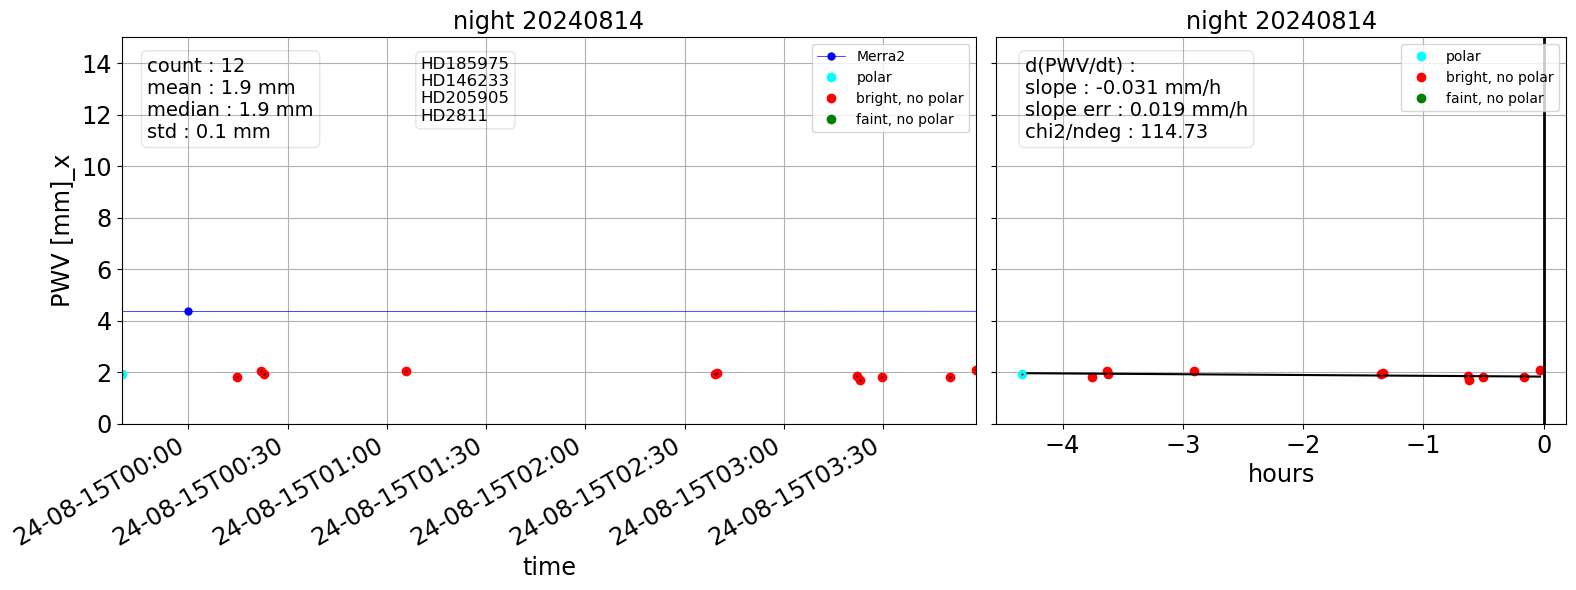

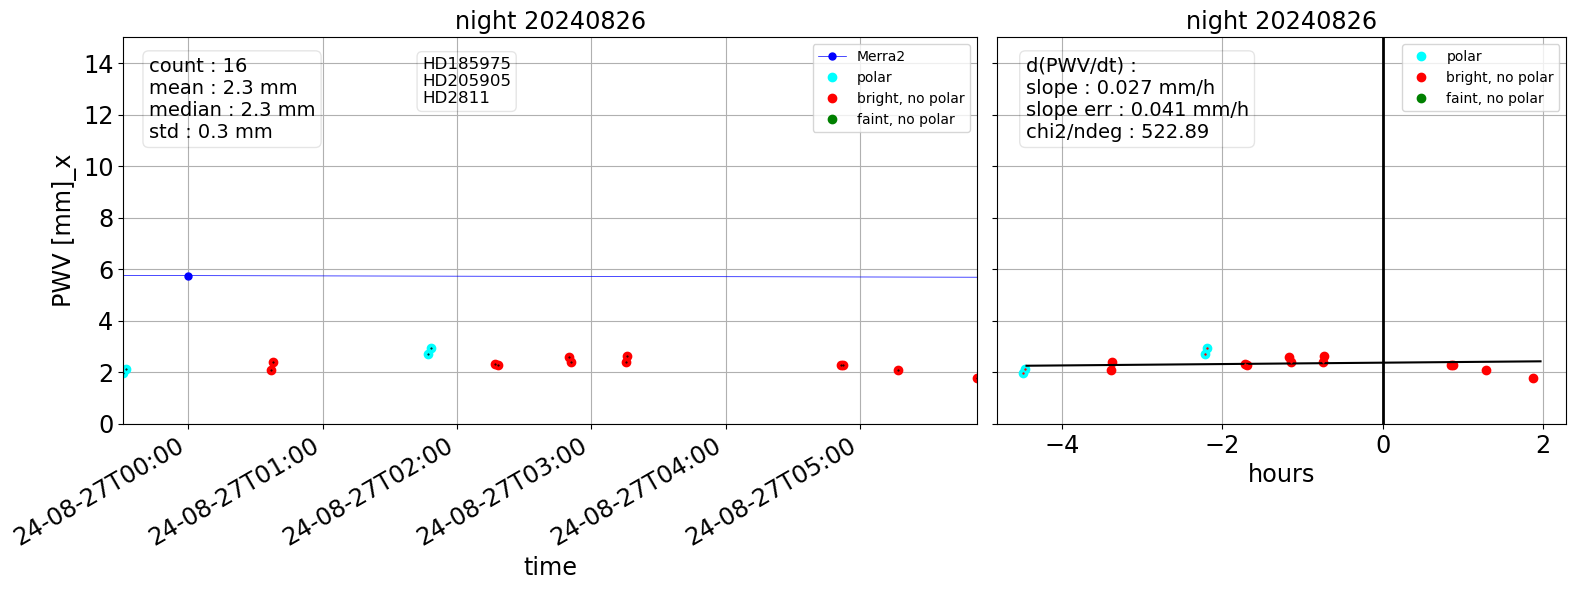

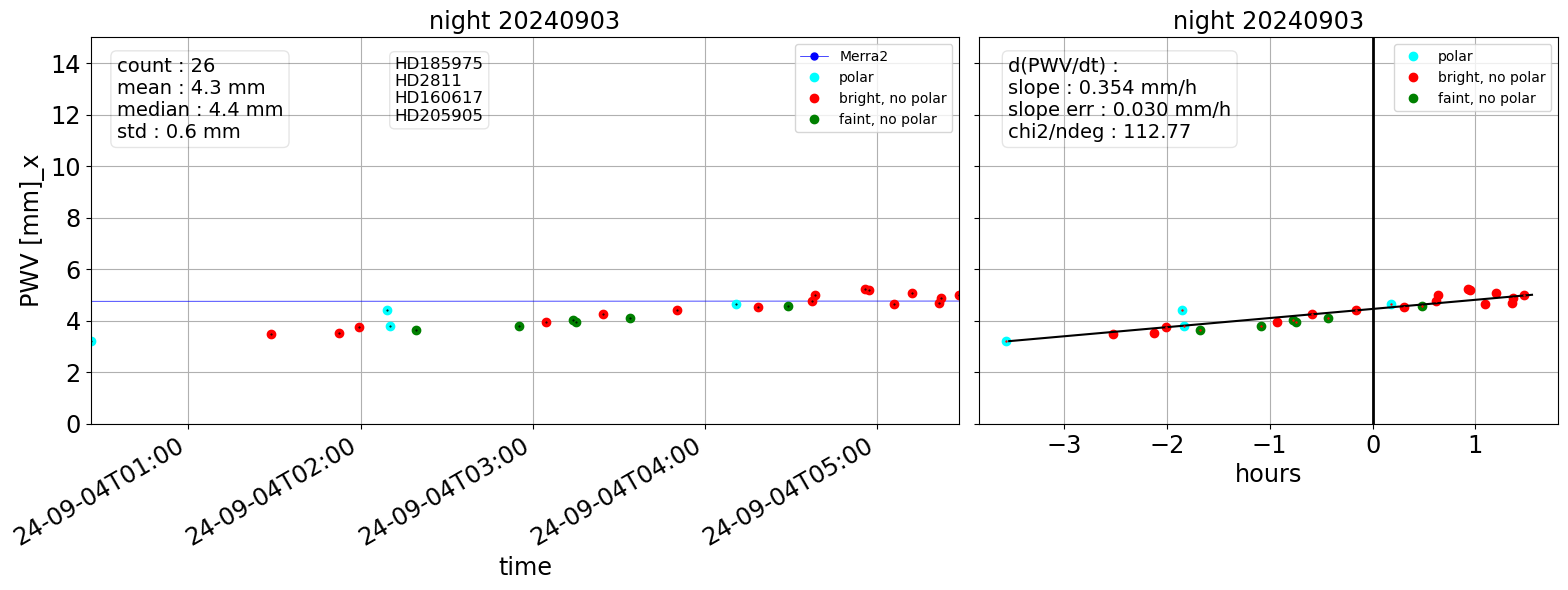

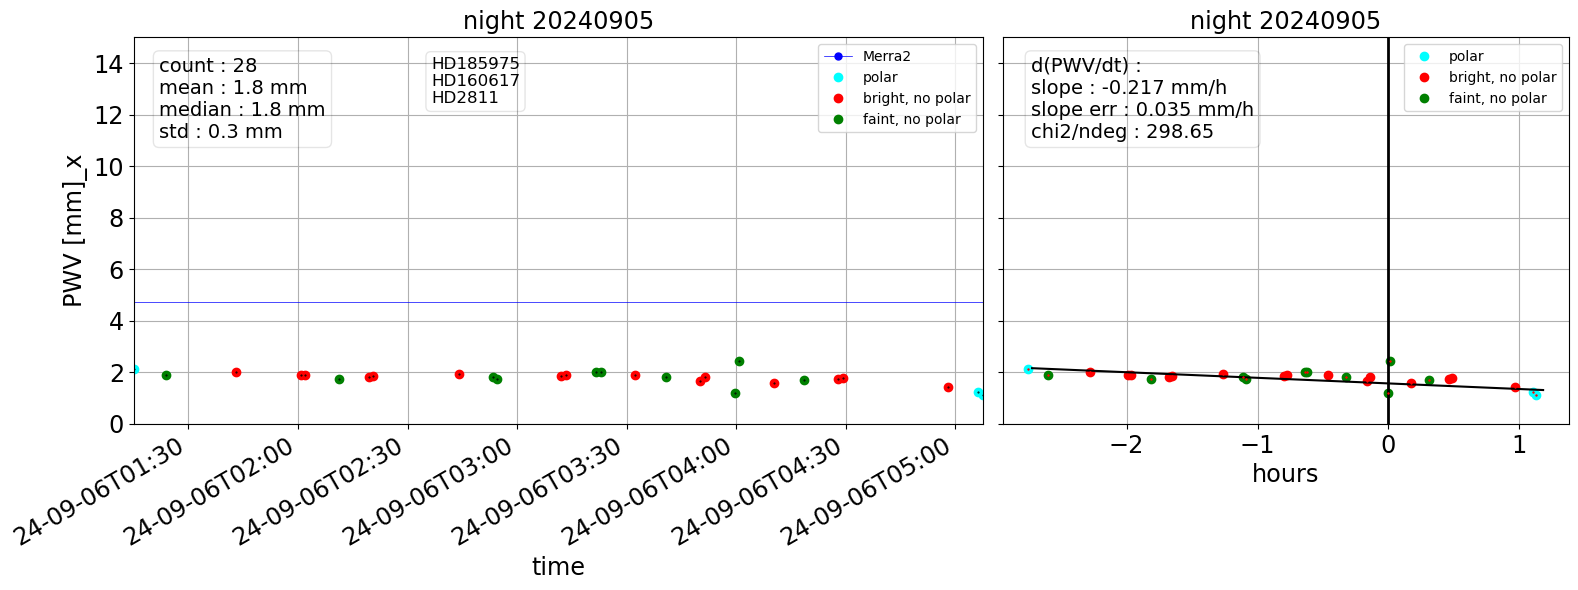

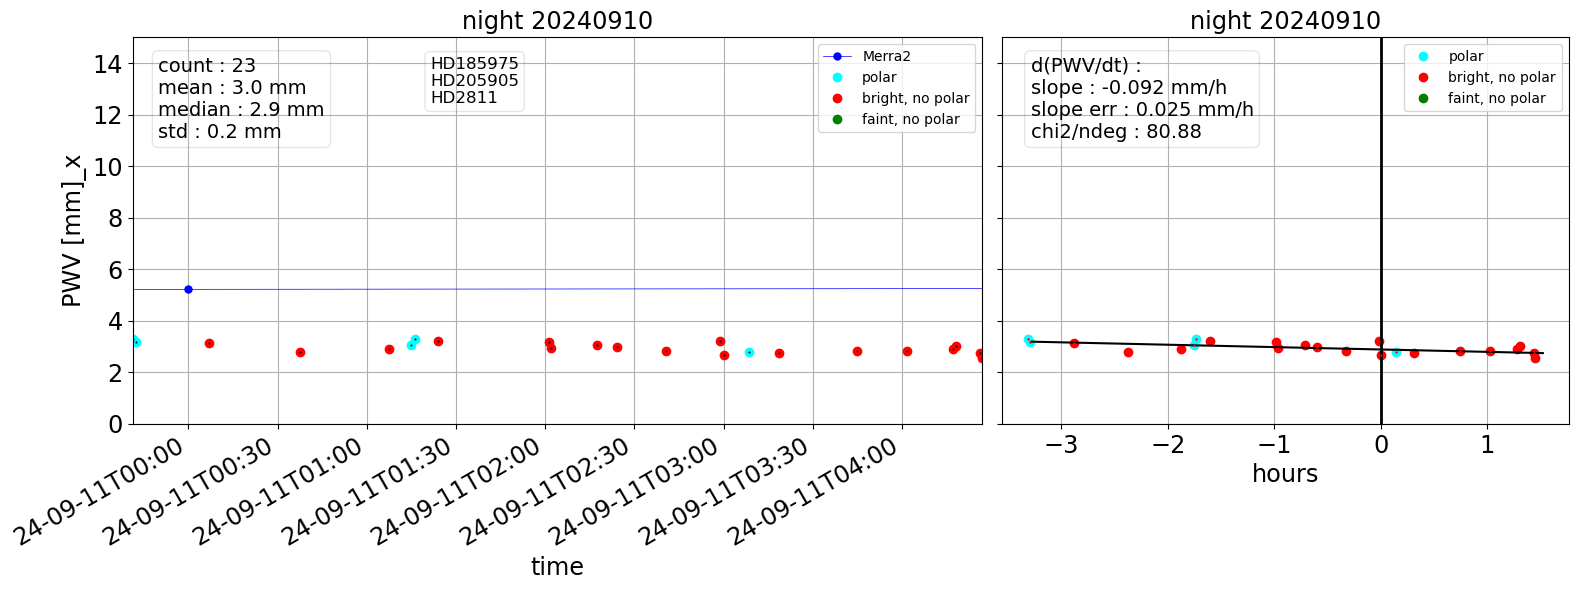

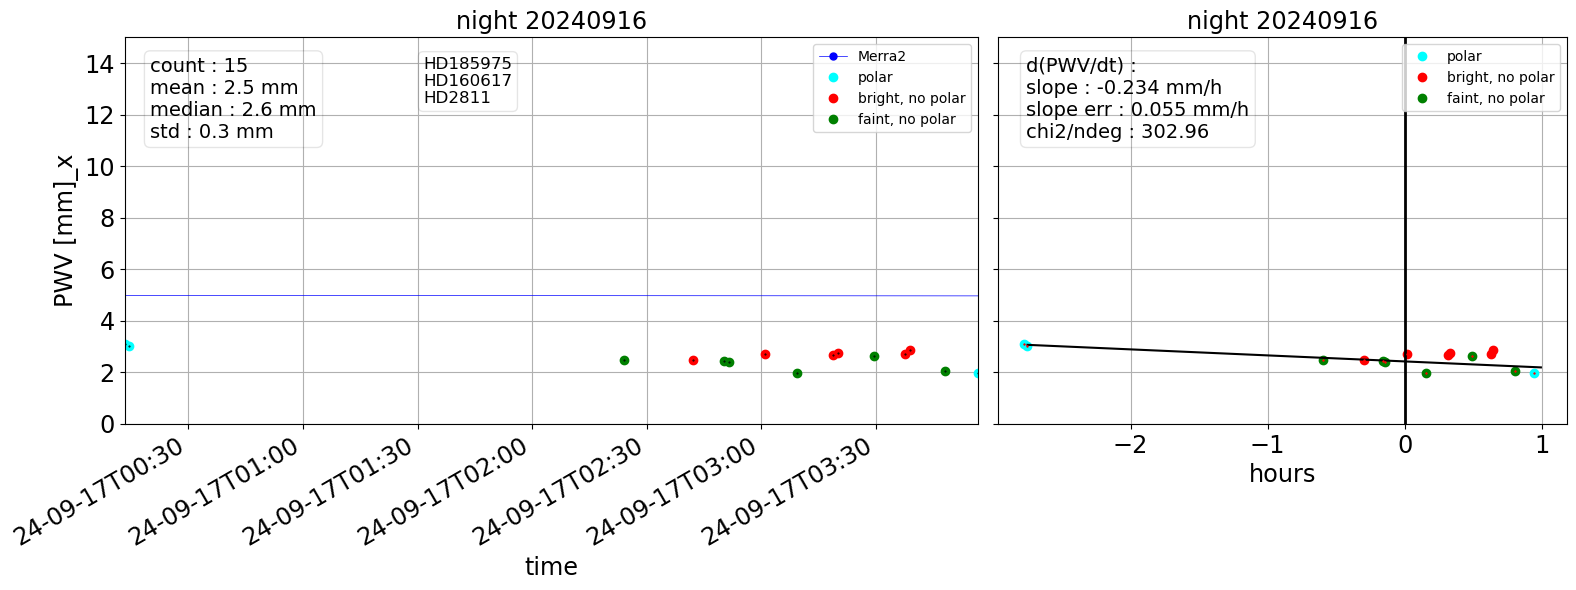

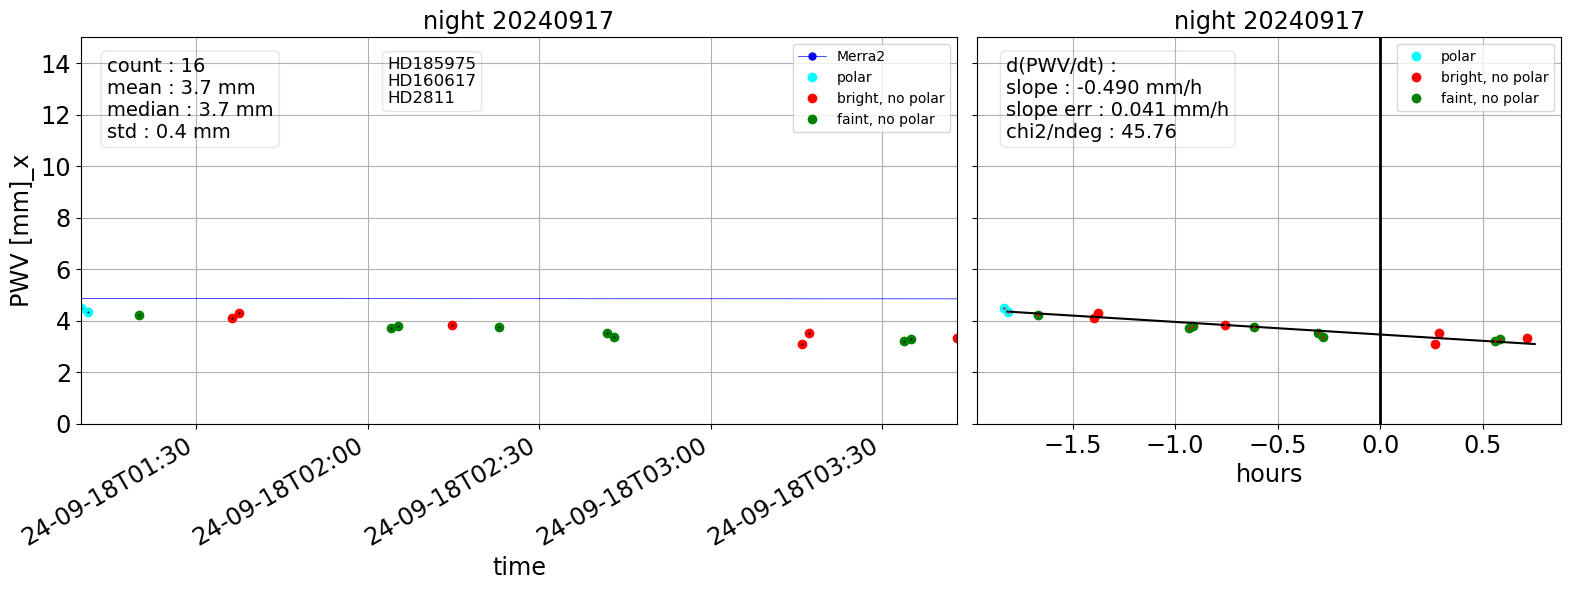

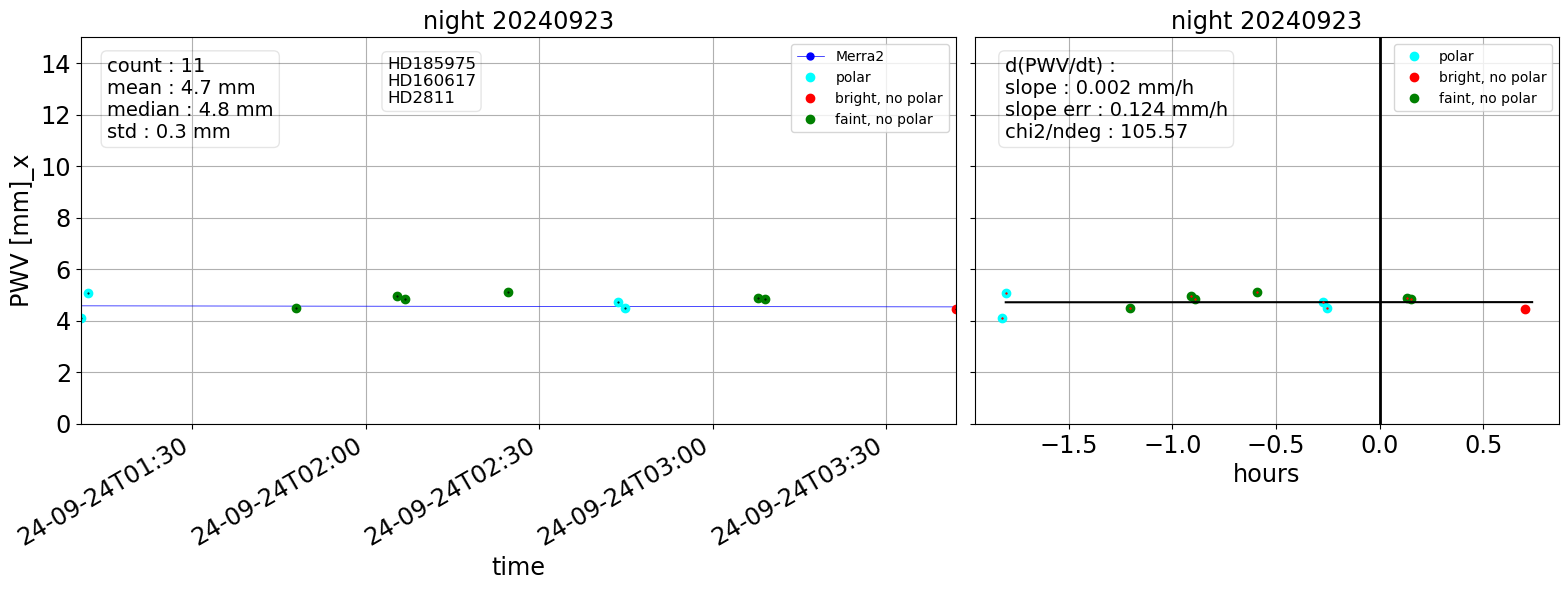

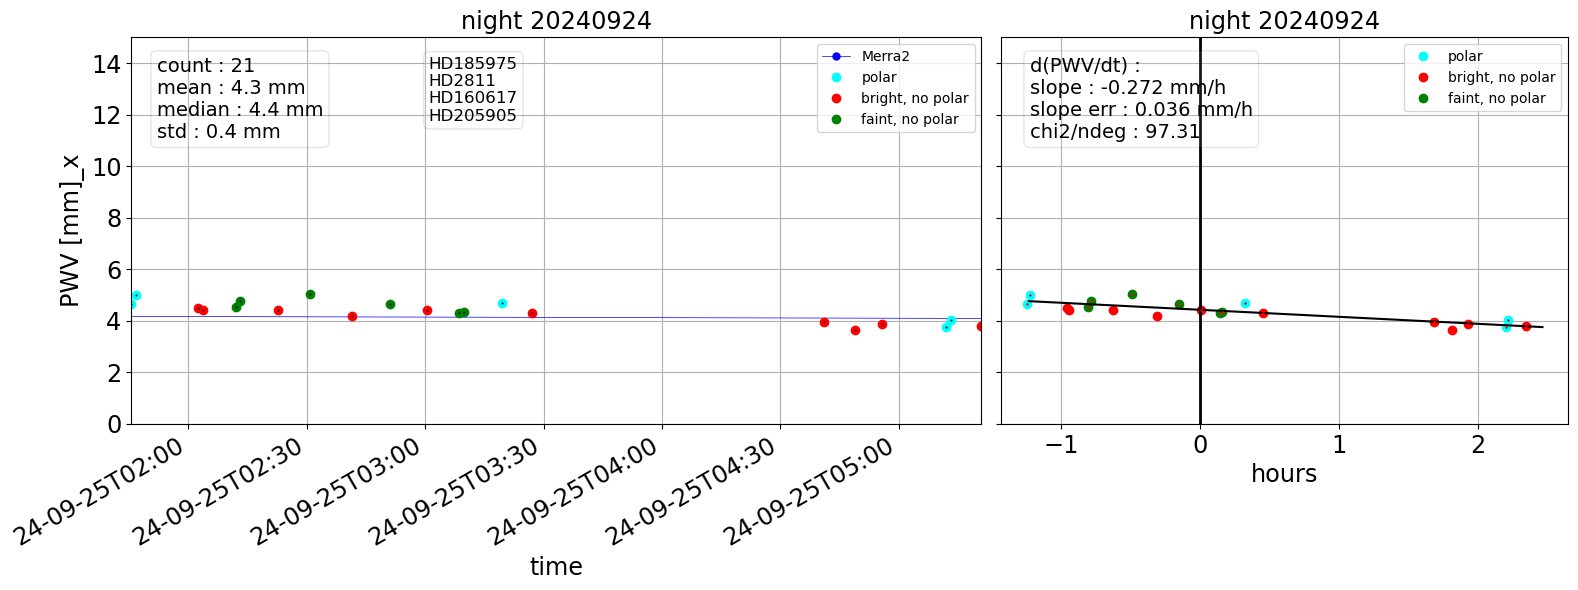

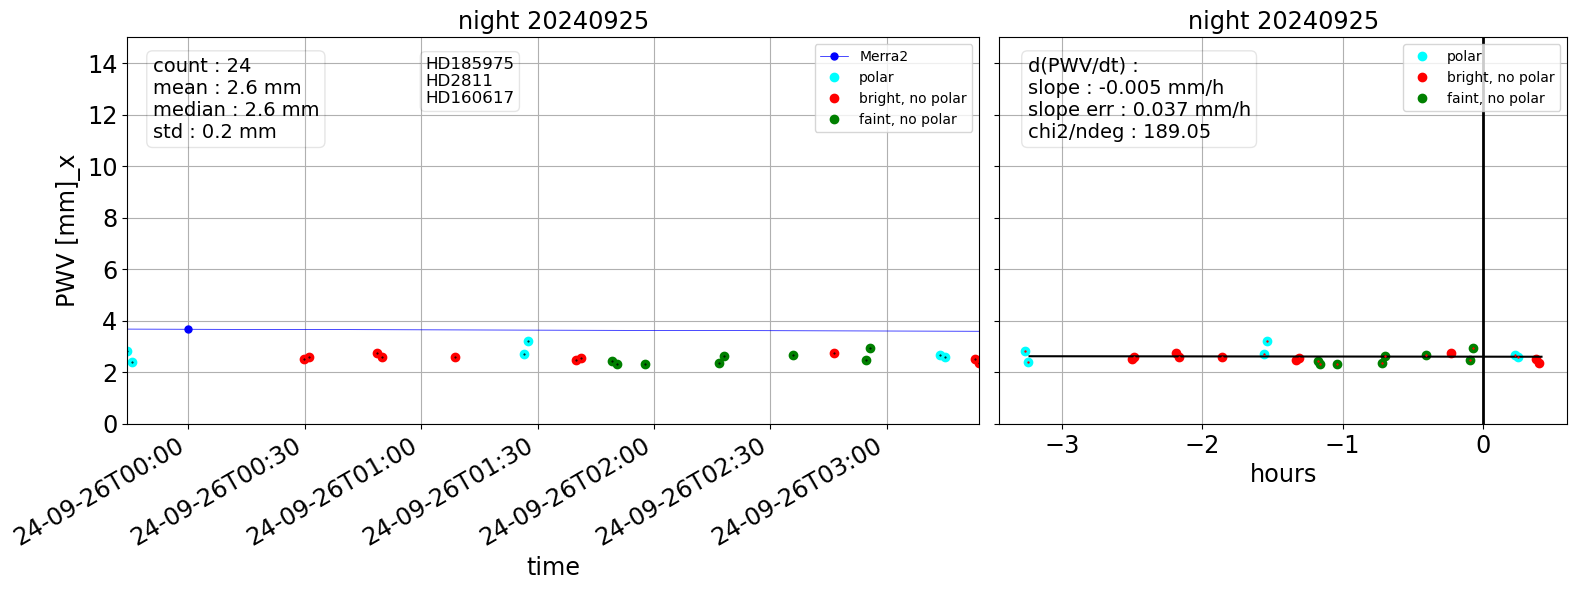

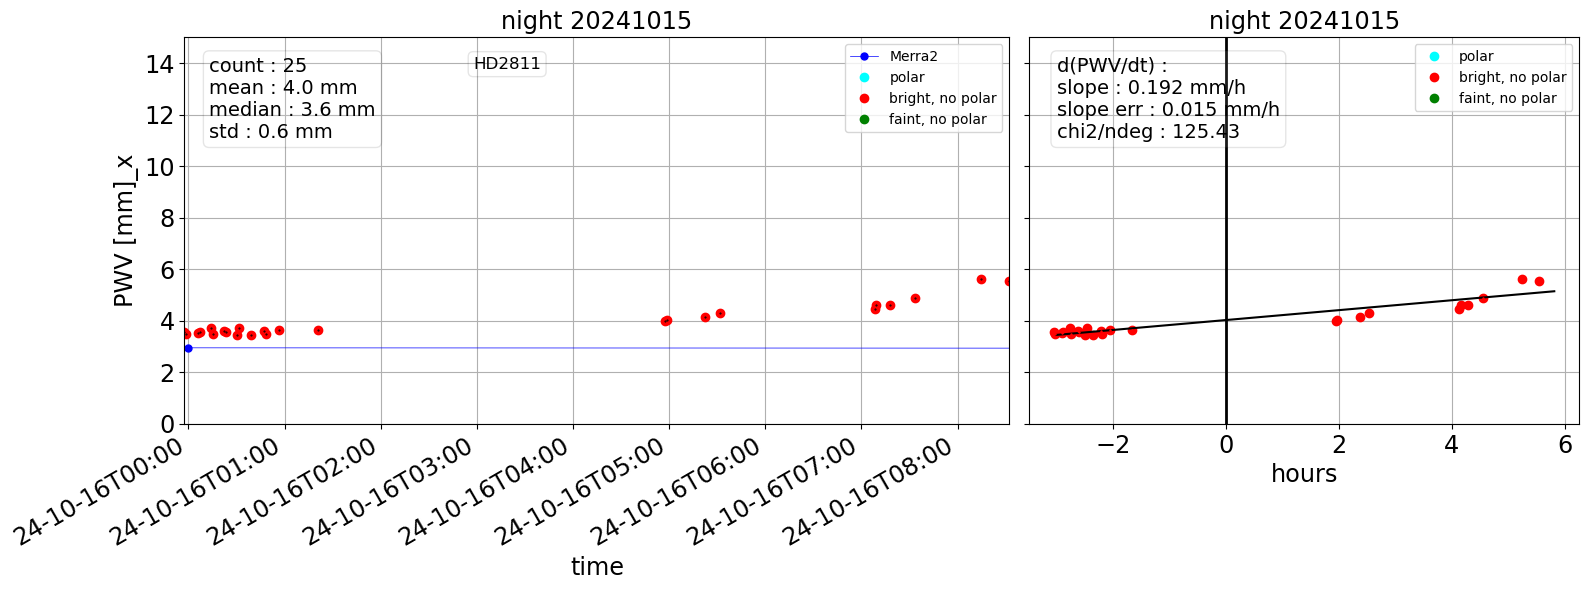

In [67]:
all_dateObs_sel = {}

# loop on nights
for night in all_selected_nights:
    #select the night
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]
    
    #select the variables
    df_night_pwv_curve = df_spec_night[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_wp = df_spec_night_wp[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np_b = df_spec_night_np_b[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np_f = df_spec_night_np_f[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np = df_spec_night_np[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]

    tmin = df_night_pwv_curve["Time"].min()
    tmax = df_night_pwv_curve["Time"].max()

    list_of_targets = df_night_pwv_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)
     

    # convert in hours
    df_night_pwv_curve["dt"] = (df_night_pwv_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_wp["dt"] = (df_night_pwv_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np["dt"] = (df_night_pwv_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np_f["dt"] = (df_night_pwv_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np_b["dt"] = (df_night_pwv_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    
    # extract statistics on pwv
    stat = df_night_pwv_curve[["PWV [mm]_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    #date_form = DateFormatter("%y-%m-%dT%H")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f} mm",
                     f"median : {median:.1f} mm",
                     f"std : {std:.1f} mm",
                    ))


    N= len(df_night_pwv_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_pwv_curve)
            
   
        
        textstr2 = "\n".join((f"d(PWV/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(PWV/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",  
                    ))
    

        stat.loc["slope","PWV [mm]_x"] = slope 
        stat.loc["slope_err","PWV [mm]_x"] = slope_err 
        stat.loc["chi2","PWV [mm]_x"] = chi2dof
        
        # plot
      
        
        fig = plt.figure(figsize=(16,6))
        gs = GridSpec(1, 2,  width_ratios=[1.5,1],figure=fig)

        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1],sharey=ax)
        
        leg=ax.get_legend()
        leg2=ax2.get_legend()
      
        
        # left figure
        ax.set_xlim(tmin,tmax)
        df_m.plot(x="Time",y="TQV",ax=ax,marker="o",c="b",lw=0.5,ms=5,label="Merra2",legend=leg)  
        
        #df_night_pwv_curve.plot(x="Time",y="PWV [mm]_x",c="k",ax=ax,marker='+',lw=0.0,grid=True,legend=leg,label="all",ms=8,alpha=1)
        ax.errorbar(x=df_night_pwv_curve.Time, y=df_night_pwv_curve["PWV [mm]_x"],yerr=df_night_pwv_curve["PWV [mm]_err_x"],fmt=".",color="k",ecolor="k",lw=1,ms=1)
        df_night_pwv_curve_wp.plot(x="Time",y="PWV [mm]_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_pwv_curve_np_b.plot(x="Time",y="PWV [mm]_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_pwv_curve_np_f.plot(x="Time",y="PWV [mm]_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)
        
        

        
        ax.legend(loc="upper right")
        ax.set_ylabel("PWV [mm]_x")
        ax.set_xlabel("time")
        ax.xaxis.set_major_formatter(date_form)
        ax.set_ylim(0.,15.)
        ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
        #ax.text(0.35, 0.95, textstr3, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)
        ax.text(0.35, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        ax.set_title(f"night {night}")
        

        # right figure
        ax2.errorbar(x=df_night_pwv_curve.dt_midnight, y=df_night_pwv_curve["PWV [mm]_x"],yerr=df_night_pwv_curve["PWV [mm]_err_x"],fmt="+",color="r",ecolor="k",ms=1)
        df_night_pwv_curve_wp.plot(x="dt_midnight",y="PWV [mm]_x",c="cyan",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="polar",ms=6,alpha=1)
        df_night_pwv_curve_np_b.plot(x="dt_midnight",y="PWV [mm]_x",c="r",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="bright, no polar",ms=6,alpha=1)
        df_night_pwv_curve_np_f.plot(x="dt_midnight",y="PWV [mm]_x",c="g",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="faint, no polar",ms=6,alpha=1)
        ax2.set_xlabel("hours")
        ax2.set_ylim(0.,15.)
        ax2.legend(loc="upper right")
        ax2.plot(xfit,yfit,"k-")
        ax2.text(0.05, 0.95, textstr2, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
        ax2.set_title(f"night {night}")
        ax2.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/pwv_per_night_{night}"+figtype
        plt.savefig(figname)
        plt.show()

        # add statistics
        all_dateObs_sel[night] = stat

## Plot night by night version v2 (for Blois conference)

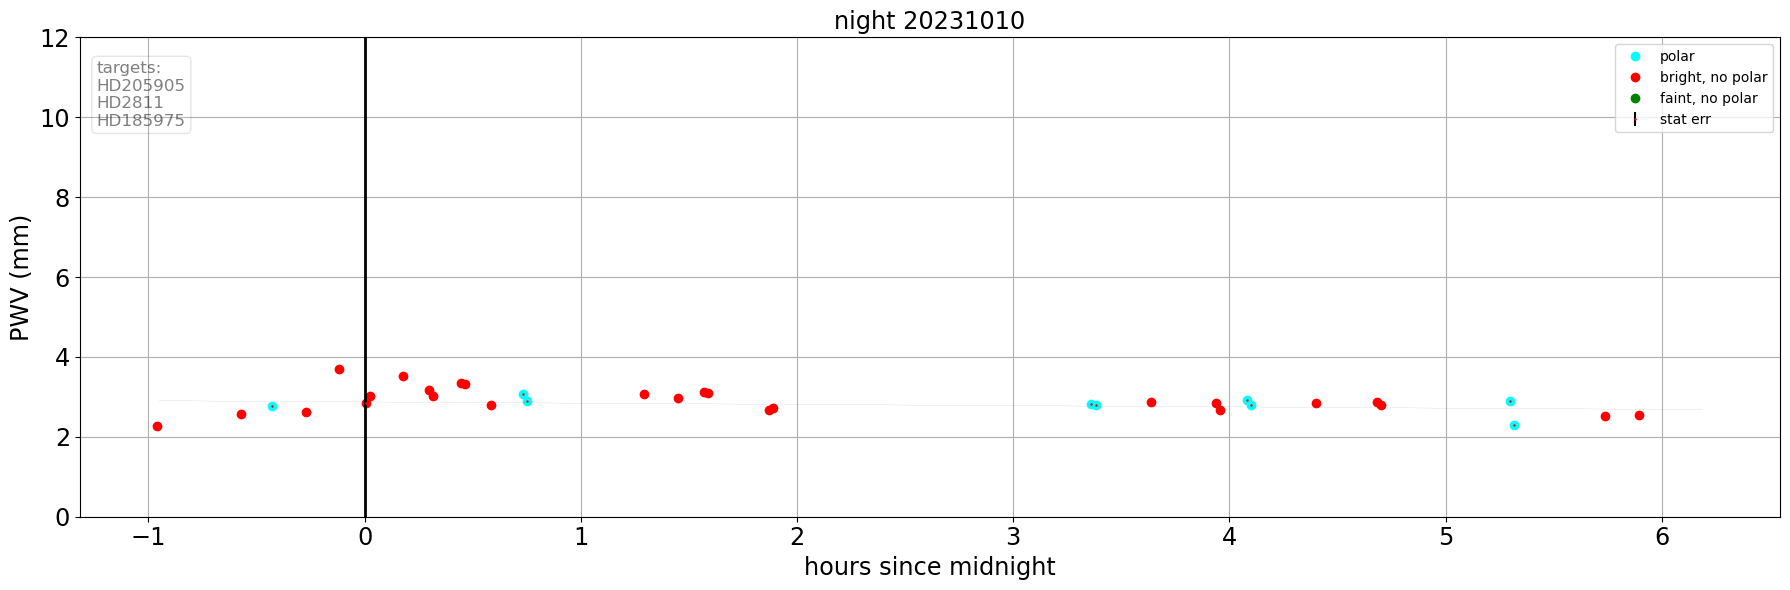

In [83]:

# loop on nights
for night in all_selected_nights:
    #select the night
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]
    
    #select the variables
    df_night_pwv_curve = df_spec_night[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_wp = df_spec_night_wp[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np_b = df_spec_night_np_b[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np_f = df_spec_night_np_f[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_pwv_curve_np = df_spec_night_np[["Time","PWV [mm]_x","PWV [mm]_err_x","PWV [mm]_y","PWV [mm]_err_y","dt_midnight","AIRMASS","TARGET"]]

    tmin = df_night_pwv_curve["Time"].min()
    tmax = df_night_pwv_curve["Time"].max()

    list_of_targets = df_night_pwv_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)
    str_list_of_targets = "\n".join(["targets:",str_list_of_targets])
     

    # convert in hours
    df_night_pwv_curve["dt"] = (df_night_pwv_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_wp["dt"] = (df_night_pwv_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np["dt"] = (df_night_pwv_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np_f["dt"] = (df_night_pwv_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    df_night_pwv_curve_np_b["dt"] = (df_night_pwv_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    
    # extract statistics on pwv
    stat = df_night_pwv_curve[["PWV [mm]_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    #date_form = DateFormatter("%y-%m-%dT%H")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f} mm",
                     f"median : {median:.1f} mm",
                     f"std : {std:.1f} mm",
                    ))


    N= len(df_night_pwv_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_pwv_curve)
            
   
        
        textstr2 = "\n".join((f"d(PWV/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(PWV/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",  
                    ))
    

        stat.loc["slope","PWV [mm]_x"] = slope 
        stat.loc["slope_err","PWV [mm]_x"] = slope_err 
        stat.loc["chi2","PWV [mm]_x"] = chi2dof
        
        # plot
      
        
        fig,ax  = plt.subplots(1,1,figsize=(18,6))
        leg=ax.get_legend()
        

        # right figure
        ax.errorbar(x=df_night_pwv_curve.dt_midnight, y=df_night_pwv_curve["PWV [mm]_x"],yerr=df_night_pwv_curve["PWV [mm]_err_x"],fmt="+",color="r",ecolor="k",label="stat err",ms=1)
        df_night_pwv_curve_wp.plot(x="dt_midnight",y="PWV [mm]_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_pwv_curve_np_b.plot(x="dt_midnight",y="PWV [mm]_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_pwv_curve_np_f.plot(x="dt_midnight",y="PWV [mm]_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)
        ax.set_xlabel("hours since midnight")
        ax.set_ylim(0.,12.)
        ax.set_ylabel("PWV (mm)")
        ax.legend(loc="upper right")
        ax.plot(xfit,yfit,"k:",lw=0.1)
        #ax.text(0.05, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax.text(0.01, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props,alpha=0.5)
        ax.set_title(f"night {night}")
        ax.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/pwv_per_night_{night}_confblois24"+figtype
        plt.savefig(figname)
        plt.show()

    


## Make a summary of Night quality

In [69]:
def GetStatistics(all_dateObs_sel):
    df = pd.DataFrame(columns = ["count","mean","median","std","slope","slope_err"])
    
    for nightObs, stat in all_dateObs_sel.items():
        count = int(stat.loc["count"].values[0])
        mean = stat.loc["mean"].values[0]
        median = stat.loc["50%"].values[0]
        std = stat.loc["std"].values[0]
        slope = stat.loc["slope"].values[0]
        slope_err = stat.loc["slope_err"].values[0]
        df.loc[nightObs] = [count,mean,median,std,slope,slope_err]
    return df

In [70]:
df = GetStatistics(all_dateObs_sel)

### Convert dateobs into datetime

In [71]:
def ComputeDataTimeStr(num):
    year = num//10000
    remain = (num-year*10000)
    month = remain//100
    day = remain-100*month
    yearstr = f"{year}"
    monthstr = f"{month}"
    daystr= f"{day}"
    stry = yearstr.zfill(4)
    strm = monthstr.zfill(2)
    strd = daystr.zfill(2)
    
    str = f"{stry}-{strm}-{strd}"
    return str

In [72]:
df["Time"] = pd.to_datetime([ ComputeDataTimeStr(num) for  num in df.index])

### Plot summary

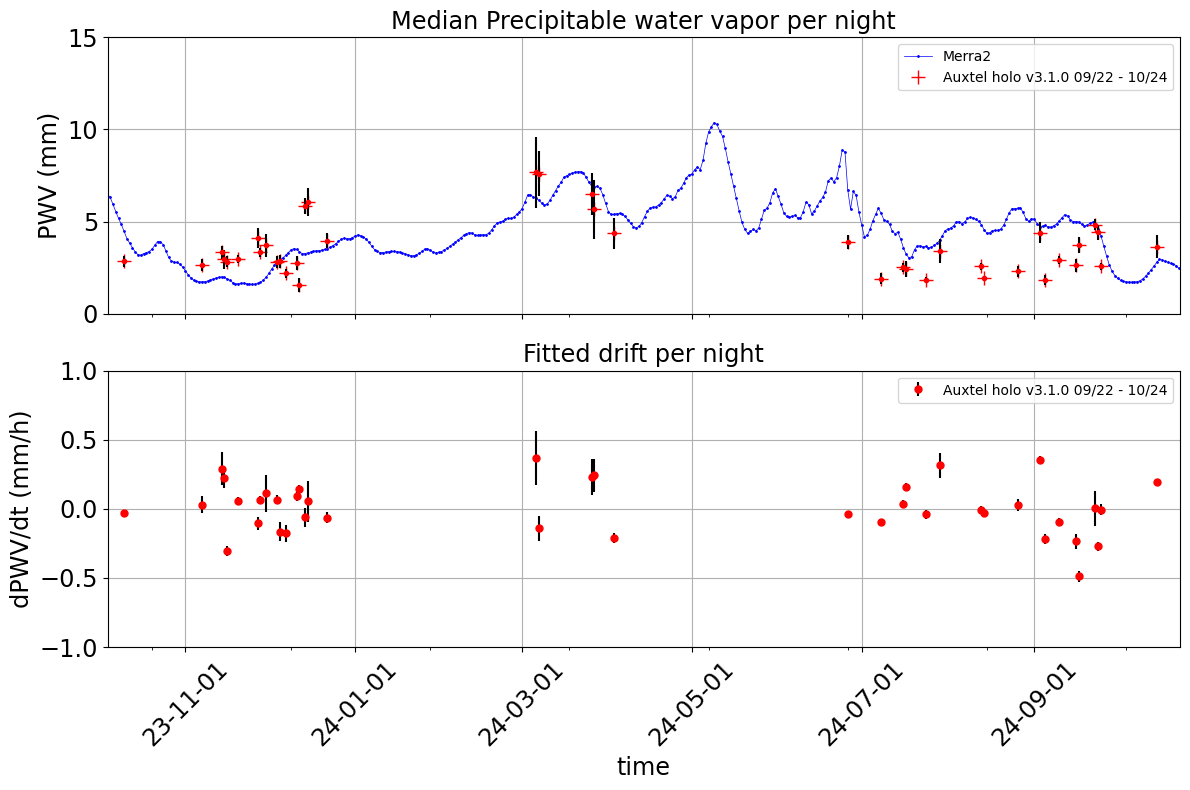

In [73]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax1,ax2  = axs


leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TQV",ax=ax1,marker="o",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)  
df.plot(x="Time",y="median",ax=ax1,marker='+',c="r",lw=0.0,grid=True,ms=10,label=tag,legend=leg1)
ax1.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt=".",color="r",ecolor="k")

ax1.set_ylabel("PWV (mm)")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("Median Precipitable water vapor per night")
ax1.set_ylim(0.,15.)
ax1.legend(loc="upper right")
ax1.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

ax2.set_title("Fitted drift per night")
ax2.errorbar(x=df["Time"], y=df["slope"],yerr=df["slope_err"],fmt=".",color="r",ecolor="k",ms=10,label=tag,legend=leg2)
ax2.grid()
ax2.set_ylabel("dPWV/dt (mm/h)")
ax2.set_xlabel("time")
ax2.set_ylim(-1.,1.)
ax2.xaxis.set_major_formatter(date_form)
ax2.legend(loc="upper right")
ax2.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

ax2.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
figname =f"{pathfigs}/pwv_medianspredslope_allnights"+figtype
plt.savefig(figname)
plt.show()

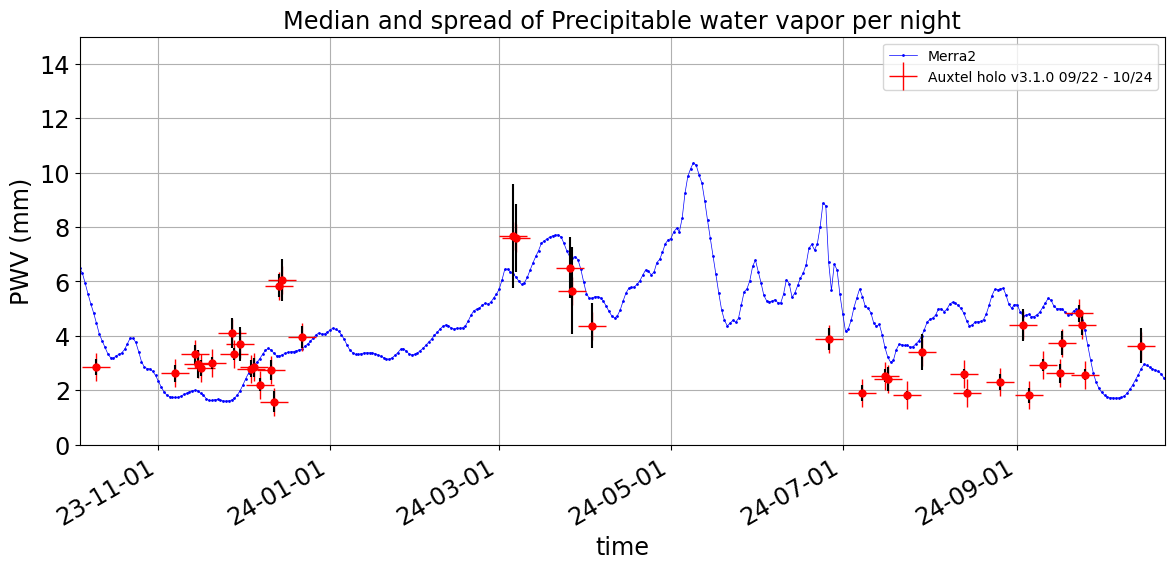

In [74]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TQV",ax=ax,marker="o",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)  
df.plot(x="Time",y="median",ax=ax,marker='+',c="r",ms=20,lw=0.0,grid=True,label=tag,legend=leg)
ax.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt="o",ms=5,color="r",ecolor="k")
ax.set_ylabel("PWV (mm)")
ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Median and spread of Precipitable water vapor per night")
ax.set_ylim(0.,15)
ax.legend(loc="upper right")

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

figname =f"{pathfigs}/pwv_medians_allnights"+figtype
plt.savefig(figname)
plt.show()